In [55]:
# Step 1 - Setup Environment and Import Libraries
import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

# Configure logging
logging.basicConfig(
    filename=os.path.join(os.getcwd(), "analysis.log"),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

BASE_DIR = os.getcwd()  # Simplified for Jupyter
CACHE_DIR = os.getenv("FASTF1_CACHE_DIR", os.path.join(BASE_DIR, "fastf1_cache"))
HISTORICAL_CACHE_DIR = os.getenv("HISTORICAL_CACHE_DIR", os.path.join(BASE_DIR, "historical_cache"))
try:
    os.makedirs(CACHE_DIR, exist_ok=True)
    os.makedirs(HISTORICAL_CACHE_DIR, exist_ok=True)
except OSError as e:
    logger.error(f"Failed to create cache directory at {CACHE_DIR} or {HISTORICAL_CACHE_DIR}: {e}")
    raise RuntimeError(f"Failed to create cache directory: {e}")

fastf1.set_log_level('ERROR')
fastf1.Cache.enable_cache(CACHE_DIR)

if os.getenv("SILENT", "false").lower() != "true":
    print("Library Versions:")
    print(f"FastF1: {fastf1.__version__}")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Matplotlib: {plt.matplotlib.__version__}")
    print(f"\nCache Directory: {os.path.abspath(CACHE_DIR)}")
    print(f"Historical Cache Directory: {os.path.abspath(HISTORICAL_CACHE_DIR)}")
    print(f"Cache Directory Exists: {os.path.exists(CACHE_DIR)}")
    print(f"Historical Cache Directory Exists: {os.path.exists(HISTORICAL_CACHE_DIR)}")
    print(f"Current Date: {datetime.now().strftime('%Y-%m-%d')}")
    logger.info("Environment setup completed successfully.")

# Why: Sets up the environment with necessary libraries and caching for F1 data analysis.
# How to Read: Displays library versions and cache status to confirm setup.
# Expected Inputs: None
# Expected Outputs: Console confirmation of setup
# Data Exported: analysis.log (optional log file)

2025-03-19 11:25:57,609 - INFO - Environment setup completed successfully.


Library Versions:
FastF1: 3.5.0
Pandas: 2.2.3
NumPy: 1.26.4
Matplotlib: 3.10.0

Cache Directory: C:\data\Dropbox\dev\F1\fastf1_cache
Historical Cache Directory: C:\data\Dropbox\dev\F1\historical_cache
Cache Directory Exists: True
Historical Cache Directory Exists: True
Current Date: 2025-03-19


In [56]:
# Step 2: Get Target Event
import fastf1
import pandas as pd
import logging
import os

# Configure logging
logger = logging.getLogger(__name__)

# Generic track lengths by FastF1 Location (in kilometers)
# Sourced from official F1 data and historical records, aligned with FastF1's Location field
TRACK_LENGTHS = {
    'Sakhir': 5.412,       # Bahrain International Circuit
    'Jeddah': 6.174,       # Jeddah Corniche Circuit
    'Melbourne': 5.278,    # Albert Park Circuit
    'Suzuka': 5.807,       # Suzuka International Racing Course
    'Shanghai': 5.513,     # Shanghai International Circuit
    'Miami': 5.793,        # Miami International Autodrome
    'Imola': 4.318,        # Autodromo Enzo e Dino Ferrari
    'Monaco': 7.004,       # Circuit de Monaco
    'Montréal': 5.891,     # Circuit Gilles Villeneuve
    'Spielberg': 4.381,    # Red Bull Ring
    'Silverstone': 4.574,  # Silverstone Circuit
    'Budapest': 4.940,     # Hungaroring
    'Spa-Francorchamps': 4.655,  # Circuit de Spa-Francorchamps
    'Zandvoort': 4.259,    # Circuit Zandvoort
    'Monza': 5.063,        # Autodromo Nazionale Monza
    'Baku': 5.554,         # Baku City Circuit
    'Singapore': 5.848,    # Marina Bay Street Circuit
    'Austin': 5.281,       # Circuit of The Americas
    'Mexico City': 4.304,  # Autodromo Hermanos Rodriguez
    'São Paulo': 4.309,    # Autodromo Jose Carlos Pace
    'Las Vegas': 5.419,    # Las Vegas Strip Circuit
    'Lusail': 5.543,       # Losail International Circuit
    'Yas Island': 5.338,   # Yas Marina Circuit
    # Add more tracks as needed for future seasons
}

def get_target_event(year, round_number, skip_timing_validation=False):
    """
    Fetch target event details for a given year and round.

    Args:
        year (int): Race year (e.g., 2024)
        round_number (int): Round number (e.g., 3)
        skip_timing_validation (bool): Skip timing validation for faster execution

    Returns:
        dict: Target event details
    """
    logger.info(f"Fetching {year} schedule...")
    schedule = fastf1.get_event_schedule(year)
    logger.info(f"Fetched {year} schedule with {len(schedule)} events.")

    if round_number not in schedule['RoundNumber'].values:
        raise ValueError(f"Round {round_number} not found in {year} schedule.")

    event_row = schedule[schedule['RoundNumber'] == round_number].iloc[0]
    event_name = event_row['EventName']
    location = event_row['Location']
    session_types = [event_row[f'Session{i}'] for i in range(1, 6) if pd.notna(event_row[f'Session{i}']) and event_row[f'Session{i}'] in ['Practice 1', 'Practice 2', 'Practice 3', 'Sprint Qualifying', 'Sprint']]
    session_types = session_types[:3]  # Limit to first three sessions (pre-qualifying)

    # Fetch historical winners and pole sitters
    historical_winners = []
    historical_poles = []
    try:
        event = fastf1.get_event(year, round_number)
        for past_year in range(year - 5, year):
            try:
                past_race = fastf1.get_event(past_year, location)
                race_session = past_race.get_session('Race')
                race_session.load()
                winner = race_session.results.iloc[0]['FullName']
                historical_winners.append((past_year, winner, 1))
                quali_session = past_race.get_session('Qualifying')
                quali_session.load()
                pole_sitter = quali_session.results.iloc[0]['FullName']
                historical_poles.append((past_year, pole_sitter, 1))
            except Exception as e:
                logger.warning(f"Failed to fetch historical data for {location} in {past_year}: {e}")
    except Exception as e:
        logger.warning(f"Failed to fetch historical data for {location}: {e}")
        historical_winners.append(('N/A', 'Unknown', 1))
        historical_poles.append(('N/A', 'Unknown', 1))

    # Fetch track metadata (length, avg speed, downforce level)
    track_length = None
    avg_speed = None
    downforce_level = None
    try:
        session = fastf1.get_session(year, round_number, 'Practice 1')
        session.load(laps=True, telemetry=False, weather=False)
        circuit_info = session.get_circuit_info()
        track_length = circuit_info.length / 1000 if hasattr(circuit_info, 'length') else None
        # Estimate avg_speed and downforce_level if possible
        if track_length and 'LapTime' in session.laps.columns:
            avg_lap_time = pd.to_timedelta(session.laps['LapTime']).dt.total_seconds().mean()
            avg_speed = (track_length * 3600) / avg_lap_time if avg_lap_time > 0 else None
            downforce_level = 'Medium'  # Simplified; could be enhanced with telemetry data
    except Exception as e:
        logger.warning(f"Failed to fetch track metadata: {e}")

    # Fallback to predefined track lengths by location if not fetched
    if track_length is None:
        track_length = TRACK_LENGTHS.get(location, 5.0)  # Default to 5.0 km if not found
        logger.warning(f"Using predefined track length for {location}: {track_length} km")

    target_info = {
        'year': year,
        'round': round_number,
        'session_types': session_types,
        'event_name': event_name,
        'event_date': event_row['EventDate'].strftime('%Y-%m-%d'),
        'location': location,
        'historical_winners': historical_winners,
        'historical_poles': historical_poles,
        'track_length': track_length,
        'avg_speed': avg_speed,
        'downforce_level': downforce_level
    }

    logger.info(f"Target event selected: {event_name} (Round {round_number}) with sessions {session_types}")
    return target_info

# Standalone execution for debugging (runs only if cell is executed directly)
if __name__ == "__main__":
    # Example usage for testing
    year = 2024
    round_number = 9
    try:
        target_info = get_target_event(year, round_number, skip_timing_validation=True)
        print(f"\nFull Event Row from Schedule:\n{fastf1.get_event_schedule(year)[fastf1.get_event_schedule(year)['RoundNumber'] == round_number].iloc[0]}")
        print(f"Debug - Step 2 result: {target_info}")
    except Exception as e:
        print(f"Error during standalone execution: {e}")

# Why: Fetches target event details for analysis.
# How to Read: Outputs event details, historical data, and track metadata.
# Expected Inputs: Year and round number
# Expected Outputs: Dictionary with event details

2025-03-19 11:25:59,135 - INFO - Fetching 2024 schedule...
2025-03-19 11:25:59,201 - INFO - Fetched 2024 schedule with 25 events.
2025-03-19 11:30:40,050 - WARNING - Using predefined track length for Montréal: 5.891 km
2025-03-19 11:30:40,052 - INFO - Target event selected: Canadian Grand Prix (Round 9) with sessions ['Practice 1', 'Practice 2', 'Practice 3']



Full Event Row from Schedule:
RoundNumber                                                9
Country                                               Canada
Location                                            Montréal
OfficialEventName    FORMULA 1 AWS GRAND PRIX DU CANADA 2024
EventDate                                2024-06-09 00:00:00
EventName                                Canadian Grand Prix
EventFormat                                     conventional
Session1                                          Practice 1
Session1Date                       2024-06-07 13:30:00-04:00
Session1DateUtc                          2024-06-07 17:30:00
Session2                                          Practice 2
Session2Date                       2024-06-07 17:00:00-04:00
Session2DateUtc                          2024-06-07 21:00:00
Session3                                          Practice 3
Session3Date                       2024-06-08 12:30:00-04:00
Session3DateUtc                          2024-06-08 16

In [57]:
# Step 3 - Download Practice Session Data
# Objective: Retrieve data for all practice sessions, extract key indicators, compute track metadata, save as CSV, and preview for verification.

import fastf1
import pandas as pd
import numpy as np
import os
from IPython.display import display
import logging

logger = logging.getLogger(__name__)

def download_practice_data(target_info):
    year = target_info['year']
    round_number = target_info['round']
    session_labels = target_info['session_types']
    event_name = target_info['event_name']

    # Directory to save raw data (structured as raw_data/{year}/R{round_number}/)
    BASE_DIR = os.getcwd()
    data_dir = os.path.join(BASE_DIR, "raw_data", str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)  # Ensure directory exists

    # Debug: Verify event schedule
    schedule = fastf1.get_event_schedule(year)
    print(f"Debug - {year} Schedule Length: {len(schedule)}")
    event = schedule[schedule['RoundNumber'] == round_number]
    if event.empty:
        raise ValueError(f"No event found for Round {round_number} in {year}. Available rounds: {schedule['RoundNumber'].tolist()}")
    print(f"Debug - Selected Event: {event['EventName'].iloc[0]} (Round {round_number})")

    # Dictionary to store session data
    session_data = {}

    # Compute track metadata using FP1
    try:
        fp1_session = fastf1.get_session(year, event_name, 'FP1')
        fp1_session.load(telemetry=True)
        # Use accurate, full laps for track length
        valid_laps = fp1_session.laps[fp1_session.laps['IsAccurate'] & fp1_session.laps['LapTime'].notna()]
        top_laps = valid_laps.nlargest(5, 'LapTime')  # Top 5 accurate laps
        lap_lengths = []
        for _, lap in top_laps.iterrows():
            telemetry = lap.get_telemetry()
            lap_length = (telemetry['Distance'].max() - telemetry['Distance'].min()) / 1000  # km
            lap_lengths.append(lap_length)
        track_length = np.mean(lap_lengths)  # Average for consistency
        target_info['track_length'] = track_length

        # Average speed: based on fastest lap and computed track length
        fastest_lap = fp1_session.laps.pick_fastest()
        lap_time_seconds = fastest_lap['LapTime'].total_seconds()
        avg_speed = (track_length / (lap_time_seconds / 3600))  # km/h
        target_info['avg_speed'] = avg_speed

        # Downforce level (heuristic)
        telemetry = fastest_lap.get_telemetry()
        speeds = telemetry['Speed']
        top_speed = speeds.max()
        corner_speeds = speeds[telemetry['Throttle'] < 90]  # Proxy for corners
        avg_corner_speed = corner_speeds.mean() if not corner_speeds.empty else top_speed / 2
        corner_to_straight_ratio = avg_corner_speed / top_speed
        circuit_info = fp1_session.get_circuit_info()
        corner_count = len(circuit_info.corners)
        if corner_count > 15 and corner_to_straight_ratio > 0.7:
            downforce_level = 'High'
        elif corner_count > 10 and corner_to_straight_ratio > 0.5:
            downforce_level = 'Medium-High'
        elif corner_count > 5 and corner_to_straight_ratio > 0.3:
            downforce_level = 'Medium'
        else:
            downforce_level = 'Low'
        target_info['downforce_level'] = downforce_level

        print(f"\nComputed Track Metadata (from FP1):")
        print(f"Track Length: {track_length:.3f} km")
        print(f"Average Speed: {avg_speed:.1f} km/h")
        print(f"Downforce Level: {downforce_level}")
    except Exception as e:
        logger.error(f"Failed to compute track metadata: {e}")
        print(f"Warning: Track metadata computation failed: {e}")
        target_info['track_length'] = target_info.get('track_length', 'TBD')
        target_info['avg_speed'] = target_info.get('avg_speed', 'TBD')
        target_info['downforce_level'] = target_info.get('downforce_level', 'TBD')

    # Download and process each session
    for session_num, session_label in enumerate(session_labels, start=1):
        print(f"\nDownloading Session {session_num} ({session_label}) data...")
        session = fastf1.get_session(year, event_name, session_label)
        session.load(telemetry=True)
        logger.info(f"Loaded data for {session_label} with {len(session.laps)} laps.")

        # Extract lap data
        laps = session.laps
        session_data[session_label] = {'laps': laps}

        # Save lap data
        file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_laps.csv")
        laps.to_csv(file_path, index=False)
        print(f"Saved {session_label} lap data to {file_path}")

        # Extract weather data
        weather = session.weather_data
        session_data[session_label]['weather'] = weather
        weather_file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_weather.csv")
        weather.to_csv(weather_file_path, index=False)
        print(f"Saved {session_label} weather data to {weather_file_path}")

        # Compute indicators
        fastest_laps = laps.groupby('Driver')['LapTime'].min().reset_index()
        avg_lap_times = laps.groupby('Driver')['LapTime'].mean().reset_index().rename(columns={'LapTime': 'AvgLapTime'})
        tyre_degradation = laps[laps['Compound'].notna() & laps['TyreLife'].notna()]
        tyre_degradation = tyre_degradation.groupby(['Driver', 'Stint']).agg({
            'LapTime': lambda x: x.mean().total_seconds() if not x.empty else np.nan,
            'TyreLife': 'mean'
        }).reset_index()
        # Refined degradation rate: tighter clip and fill NaN
        tyre_degradation['DegradationRate'] = (
            tyre_degradation.groupby('Driver')
            .apply(lambda x: (x['LapTime'].diff() / x['TyreLife'].diff()).replace([np.inf, -np.inf], 0).clip(lower=-0.1, upper=0.1), include_groups=False)
            .reset_index(drop=True)
        )
        tyre_degradation = tyre_degradation.groupby('Driver')['DegradationRate'].mean().fillna(0).reset_index()
        indicators = fastest_laps.merge(avg_lap_times, on='Driver').merge(tyre_degradation, on='Driver', how='left')
        session_data[session_label]['indicators'] = indicators
        indicators_file_path = os.path.join(data_dir, f"{year}_R{round_number}_{session_label.replace(' ', '_')}_indicators.csv")
        indicators.to_csv(indicators_file_path, index=False)
        print(f"Saved {session_label} indicators to {indicators_file_path}")

        # Preview data
        if os.getenv("SILENT", "false").lower() != "true":
            print(f"\n{session_label} Lap Data Preview (first 5 rows):")
            display(laps.head())
            print(f"\n{session_label} Weather Data Preview (first 5 rows):")
            display(weather.head())
            print(f"\n{session_label} Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):")
            display(indicators)

    # Summary
    if os.getenv("SILENT", "false").lower() != "true":
        print("\nDownload Summary:")
        for session_label, data in session_data.items():
            print(f"{session_label}: {len(data['laps'])} laps, Columns: {list(data['laps'].columns)}")
            print(f"  Weather: {len(data['weather'])} records")
            print(f"  Indicators: {len(data['indicators'])} drivers")

    return session_data

# Example usage
session_data = download_practice_data(target_info)

# Expected Inputs: target_info dict from Step 2 (year, round, session_types, event_name)
# Expected Outputs: Track metadata, download confirmations, file paths, data previews, summary (unless SILENT=true)
# Data Exported: CSV files for each session (laps, weather, indicators) in 'raw_data', updated target_info

Debug - 2024 Schedule Length: 25
Debug - Selected Event: Canadian Grand Prix (Round 9)

Computed Track Metadata (from FP1):
Track Length: 4.326 km
Average Speed: 184.5 km/h
Downforce Level: Medium



2025-03-19 11:30:58,441 - INFO - Loaded data for Practice 1 with 133 laps.


Saved Practice 1 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_1_laps.csv
Saved Practice 1 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_1_weather.csv
Saved Practice 1 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:42:06.187000,VER,1,0 days 00:01:42.169000,1.0,1.0,0 days 00:40:25.986000,NaT,0 days 00:00:32.163000,0 days 00:00:32.806000,...,True,Red Bull Racing,0 days 00:40:25.986000,2024-06-07 17:57:51.732,12,NaN,False,,False,False
1,0 days 00:43:48.497000,VER,1,0 days 00:01:42.310000,2.0,1.0,NaT,NaT,0 days 00:00:28.479000,0 days 00:00:30.623000,...,True,Red Bull Racing,0 days 00:42:06.187000,2024-06-07 17:59:31.933,1,NaN,False,,False,True
2,0 days 00:50:15.667000,VER,1,NaT,3.0,1.0,NaT,0 days 00:45:27.777000,0 days 00:00:28.215000,NaT,...,True,Red Bull Racing,0 days 00:43:48.497000,2024-06-07 18:01:14.243,125,NaN,False,,False,False
3,0 days 00:52:01.393000,VER,1,0 days 00:01:45.726000,4.0,2.0,0 days 00:50:17.110000,NaT,0 days 00:00:32.926000,0 days 00:00:29.580000,...,False,Red Bull Racing,0 days 00:50:17.110000,2024-06-07 18:07:42.856,1,NaN,False,,False,False
4,0 days 01:06:57.229000,VER,1,NaT,5.0,2.0,NaT,0 days 00:53:26.618000,0 days 00:00:26.187000,0 days 00:00:28.401000,...,False,Red Bull Racing,0 days 00:52:01.393000,2024-06-07 18:09:27.139,12,NaN,False,,False,False



Practice 1 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:34.879000,17.3,88.0,999.5,False,27.5,241,0.7
1,0 days 00:01:34.883000,17.3,87.0,999.4,False,27.3,245,1.5
2,0 days 00:02:34.879000,17.3,88.0,999.4,False,27.0,256,0.6
3,0 days 00:03:34.881000,17.2,87.0,999.3,False,27.1,236,0.4
4,0 days 00:04:34.879000,17.3,87.0,999.4,False,27.2,264,1.0



Practice 1 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:47.907000,0 days 00:01:50.344000,0.0
1,ALO,0 days 00:01:33.411000,0 days 00:01:38.557000,0.0
2,BOT,0 days 00:01:27.670000,0 days 00:01:44.879125,-0.1
3,DOO,0 days 00:02:06.267000,0 days 00:02:06.267000,0.0
4,GAS,0 days 00:01:27.584000,0 days 00:01:34.281833333,0.1
5,HAM,0 days 00:01:25.970000,0 days 00:01:40.493750,0.1
6,HUL,0 days 00:01:32.826000,0 days 00:01:41.363000,0.0
7,LEC,0 days 00:01:25.306000,0 days 00:01:34.204375,0.1
8,MAG,0 days 00:01:29.052000,0 days 00:01:44.439400,-0.1
9,NOR,0 days 00:01:24.435000,0 days 00:01:36.474600,0.0


2025-03-19 11:31:05,347 - INFO - Loaded data for Practice 2 with 437 laps.


Saved Practice 2 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_2_laps.csv
Saved Practice 2 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_2_weather.csv
Saved Practice 2 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_2_indicators.csv

Practice 2 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:32:56.905000,VER,1,NaT,1.0,1.0,0 days 00:15:00.655000,0 days 00:16:34.776000,NaT,0 days 00:00:31.110000,...,True,Red Bull Racing,0 days 00:15:00.655000,2024-06-07 21:00:01.978,12,NaN,False,,False,False
1,0 days 00:34:25.036000,VER,1,0 days 00:01:28.131000,2.0,2.0,0 days 00:32:58.490000,NaT,0 days 00:00:28.347000,0 days 00:00:26.697000,...,False,Red Bull Racing,0 days 00:32:56.905000,2024-06-07 21:17:58.228,1,NaN,False,,False,False
2,0 days 00:35:44.347000,VER,1,0 days 00:01:19.311000,3.0,2.0,NaT,NaT,0 days 00:00:23.035000,0 days 00:00:25.147000,...,False,Red Bull Racing,0 days 00:34:25.036000,2024-06-07 21:19:26.359,1,NaN,False,,False,True
3,0 days 00:36:57.598000,VER,1,NaT,4.0,2.0,NaT,0 days 00:36:57.598000,0 days 00:00:22.239000,0 days 00:00:24.415000,...,False,Red Bull Racing,0 days 00:35:44.347000,2024-06-07 21:20:45.670,1,NaN,False,,False,False
4,0 days 00:17:46.001000,GAS,10,0 days 00:01:45.956000,1.0,1.0,0 days 00:16:02.068000,NaT,0 days 00:00:34.374000,0 days 00:00:34.068000,...,True,Alpine,0 days 00:16:02.068000,2024-06-07 21:01:03.391,1,NaN,False,,False,False



Practice 2 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:59.943000,19.6,67.0,998.9,True,26.9,221,2.7
1,0 days 00:02:00.174000,19.6,67.0,998.9,True,26.9,239,2.2
2,0 days 00:02:59.948000,19.6,68.0,998.8,True,26.9,223,1.9
3,0 days 00:03:59.943000,19.6,68.0,998.8,True,26.9,223,1.9
4,0 days 00:04:59.945000,19.6,67.0,998.8,False,26.7,234,1.9



Practice 2 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:16.977000,0 days 00:01:31.281894736,0.000000
1,ALO,0 days 00:01:15.810000,0 days 00:01:31.605142857,0.000000
2,BOT,0 days 00:01:17.817000,0 days 00:01:34.248555555,0.100000
3,GAS,0 days 00:01:20.789000,0 days 00:01:32.199130434,-0.100000
4,HAM,0 days 00:01:16.908000,0 days 00:01:30.667260869,-0.033333
5,HUL,0 days 00:01:17.903000,0 days 00:01:34.260941176,-0.050000
6,LEC,0 days 00:01:16.556000,0 days 00:01:33.411450,0.100000
7,MAG,0 days 00:01:16.773000,0 days 00:01:31.223384615,-0.100000
8,NOR,0 days 00:01:20.843000,0 days 00:01:34.451611111,0.100000
9,OCO,0 days 00:01:17.417000,0 days 00:01:30.172857142,-0.100000


2025-03-19 11:31:11,045 - INFO - Loaded data for Practice 3 with 578 laps.


Saved Practice 3 lap data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_3_laps.csv
Saved Practice 3 weather data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_3_weather.csv
Saved Practice 3 indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_Practice_3_indicators.csv

Practice 3 Lap Data Preview (first 5 rows):


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:16:28.659000,VER,1,NaT,1.0,1.0,0 days 00:15:01.740000,NaT,NaT,0 days 00:00:25.846000,...,True,Red Bull Racing,0 days 00:15:01.740000,2024-06-08 16:30:02.448,1,NaN,False,,False,False
1,0 days 00:17:52.492000,VER,1,0 days 00:01:23.833000,2.0,1.0,NaT,NaT,0 days 00:00:22.253000,0 days 00:00:24.467000,...,True,Red Bull Racing,0 days 00:16:28.659000,2024-06-08 16:31:29.367,1,NaN,False,,False,True
2,0 days 00:19:40.195000,VER,1,0 days 00:01:47.703000,3.0,1.0,NaT,NaT,0 days 00:00:30.679000,0 days 00:00:34.842000,...,True,Red Bull Racing,0 days 00:17:52.492000,2024-06-08 16:32:53.200,1,NaN,False,,False,True
3,0 days 00:24:15.669000,VER,1,NaT,4.0,1.0,NaT,0 days 00:21:19.466000,0 days 00:00:23.554000,NaT,...,True,Red Bull Racing,0 days 00:19:40.195000,2024-06-08 16:34:40.903,125,NaN,False,,False,False
4,0 days 00:26:27.797000,VER,1,0 days 00:02:12.128000,5.0,2.0,0 days 00:25:05.044000,NaT,0 days 00:01:14.459000,0 days 00:00:25.186000,...,False,Red Bull Racing,0 days 00:25:05.044000,2024-06-08 16:40:05.752,1,NaN,False,,False,False



Practice 3 Weather Data Preview (first 5 rows):


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:05.455000,20.0,63.0,1000.8,False,32.2,262,1.4
1,0 days 00:01:05.464000,20.0,63.0,1000.7,False,32.2,96,1.2
2,0 days 00:02:05.465000,19.9,64.0,1000.8,False,32.7,103,1.4
3,0 days 00:03:05.468000,20.0,63.0,1000.7,False,32.9,79,1.7
4,0 days 00:04:05.468000,20.0,63.0,1000.6,False,33.2,67,2.0



Practice 3 Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):


,Driver,LapTime,AvgLapTime,DegradationRate
0,ALB,0 days 00:01:13.880000,0 days 00:01:27.453888888,-0.033333
1,ALO,0 days 00:01:13.340000,0 days 00:01:25.065440,-0.050000
2,BOT,0 days 00:01:13.642000,0 days 00:01:31.739142857,-0.050000
3,GAS,0 days 00:01:13.737000,0 days 00:01:28.329080,-0.050156
4,HAM,0 days 00:01:12.549000,0 days 00:01:29.479370370,-0.033333
5,HUL,0 days 00:01:13.777000,0 days 00:01:28.767434782,-0.100000
6,LEC,0 days 00:01:13.349000,0 days 00:01:31.123208333,-0.020000
7,MAG,0 days 00:01:13.439000,0 days 00:01:27.553000,-0.100000
8,NOR,0 days 00:01:13.293000,0 days 00:01:28.235214285,0.000000
9,OCO,0 days 00:01:14.075000,0 days 00:01:30.932333333,-0.100000



Download Summary:
Practice 1: 133 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weather: 78 records
  Indicators: 20 drivers
Practice 2: 437 laps, Columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
  Weat

In [58]:
# Step 4 - Clean and Aggregate Practice Data
# Objective: Clean lap data, aggregate driver stats across sessions, and prepare for predictions.

import pandas as pd
import os
from IPython.display import display
import logging

logger = logging.getLogger(__name__)

def clean_and_aggregate_data(target_info, session_data):
    year = target_info['year']
    round_number = target_info['round']
    session_types = target_info['session_types']
    BASE_DIR = os.getcwd()  # Jupyter-friendly
    DATA_DIR = os.path.join(BASE_DIR, "raw_data", str(year), f"R{round_number}")
    CLEANED_DIR = os.path.join(DATA_DIR, "cleaned_data")
    os.makedirs(CLEANED_DIR, exist_ok=True)

    if not session_data:
        logger.error("No session data provided from Step 3.")
        return {}, pd.DataFrame()

    cleaned_data = {}
    driver_summary = []
    total_raw_laps = 0
    total_cleaned_laps = 0

    for session_type, data in session_data.items():
        logger.info(f"Cleaning {session_type} data...")
        laps = data['laps']  # Use laps from session_data
        if laps.empty:
            logger.warning(f"{session_type} data is empty.")
            continue
        total_raw_laps += len(laps)
        logger.info(f"Raw Laps in {session_type}: {len(laps)}")

        # Clean laps: remove deleted, use accurate laps, drop incomplete
        clean_laps = laps[(laps['Deleted'] == False) & (laps['IsAccurate'] == True)].copy()
        logger.info(f"After Deleting Removed/Keeping Accurate: {len(clean_laps)}")
        clean_laps = clean_laps.dropna(subset=['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time'], how='all')
        logger.info(f"After Dropping Fully NaN Laps: {len(clean_laps)}")

        # Convert LapTime to seconds
        clean_laps['LapTimeSeconds'] = pd.to_timedelta(clean_laps['LapTime'], errors='coerce').dt.total_seconds()
        clean_laps = clean_laps[clean_laps['LapTimeSeconds'].notna() & (clean_laps['LapTimeSeconds'] > 0)]
        total_cleaned_laps += len(clean_laps)

        # Filter outliers and pit laps for average lap time
        clean_for_avg = clean_laps[
            (clean_laps['PitInTime'].isna()) &
            (clean_laps['PitOutTime'].isna())
        ]
        driver_medians = clean_for_avg.groupby('Driver')['LapTimeSeconds'].median()
        clean_for_avg = clean_for_avg.merge(driver_medians, on='Driver', suffixes=('', '_Median'))
        clean_for_avg = clean_for_avg[clean_for_avg['LapTimeSeconds'] <= clean_for_avg['LapTimeSeconds_Median'] * 1.3].drop(columns=['LapTimeSeconds_Median'])
        logger.info(f"Laps for AvgLapTime (After Pit/Outlier Filter): {len(clean_for_avg)}")

        # Store cleaned data
        cleaned_data[session_type] = clean_laps

        # Driver stats per session
        driver_stats = clean_for_avg.groupby('Driver').agg({
            'LapTimeSeconds': ['min', 'mean', 'std', 'count']
        }).reset_index()
        driver_stats.columns = ['Driver', 'FastestLap', 'AvgLapTime', 'LapTimeStd', 'LapCount']
        driver_stats['Session'] = session_type
        driver_summary.append(driver_stats)

        # Save cleaned laps
        cleaned_file = os.path.join(CLEANED_DIR, f"{year}_R{round_number}_{session_type.replace(' ', '_')}_cleaned_laps.csv")
        clean_laps.to_csv(cleaned_file, index=False)
        logger.info(f"Saved cleaned laps to {cleaned_file}")

    if not driver_summary:
        logger.error("No driver data aggregated.")
        overall_summary = pd.DataFrame()
    else:
        all_driver_summary = pd.concat(driver_summary, ignore_index=True)
        overall_summary = all_driver_summary.groupby('Driver').agg({
            'FastestLap': 'min',
            'AvgLapTime': 'mean',
            'LapTimeStd': 'mean',
            'LapCount': 'sum'
        }).reset_index()
        overall_summary = overall_summary.sort_values('FastestLap')
        if os.getenv("SILENT", "false").lower() != "true":
            logger.info(f"Total Raw Laps: {total_raw_laps}")
            logger.info(f"Total Cleaned Laps: {total_cleaned_laps}")
            logger.info("Driver Summary Generated (Top 5):")
            print(overall_summary.head().to_string(index=False))
            logger.info("Full Overall Driver Summary:")
            display(overall_summary)

    output_file = os.path.join(CLEANED_DIR, f"{year}_R{round_number}_practice_summary.csv")
    overall_summary.to_csv(output_file, index=False)
    logger.info(f"Saved aggregated practice summary to {output_file}")

    logger.info(f"Cleaned data keys: {list(cleaned_data.keys())}")
    return cleaned_data, overall_summary

# Example usage
cleaned_data, driver_summary = clean_and_aggregate_data(target_info, session_data)

# Why: Cleans raw lap data and aggregates driver performance stats for prediction.
# How to Read: Shows cleaned lap counts, driver stats per session, and an overall summary sorted by fastest lap.
# Expected Inputs: target_info (year, round, session_types), session_data from Step 3
# Expected Outputs: Cleaned lap CSVs, practice summary CSV, previews of top 5 and full summary
# Data Exported: Cleaned laps per session, overall driver summary

2025-03-19 11:31:11,748 - INFO - Cleaning Practice 1 data...
2025-03-19 11:31:11,751 - INFO - Raw Laps in Practice 1: 133
2025-03-19 11:31:11,762 - INFO - After Deleting Removed/Keeping Accurate: 58
2025-03-19 11:31:11,767 - INFO - After Dropping Fully NaN Laps: 58
2025-03-19 11:31:11,799 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 58
2025-03-19 11:31:11,860 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R9\cleaned_data\2024_R9_Practice_1_cleaned_laps.csv
2025-03-19 11:31:11,869 - INFO - Cleaning Practice 2 data...
2025-03-19 11:31:11,872 - INFO - Raw Laps in Practice 2: 437
2025-03-19 11:31:11,899 - INFO - After Deleting Removed/Keeping Accurate: 315
2025-03-19 11:31:11,906 - INFO - After Dropping Fully NaN Laps: 315
2025-03-19 11:31:11,931 - INFO - Laps for AvgLapTime (After Pit/Outlier Filter): 294
2025-03-19 11:31:12,084 - INFO - Saved cleaned laps to C:\data\Dropbox\dev\F1\raw_data\2024\R9\cleaned_data\2024_R9_Practice_2_cleaned_laps.csv
2025-03-1

Driver  FastestLap  AvgLapTime  LapTimeStd  LapCount
   HAM      72.549   86.503346    6.159860        42
   VER      72.923   84.886167    7.073885        21
   RUS      72.957   86.717243    5.701593        37
   STR      73.026   87.251709    3.594421        32
   PIA      73.266   85.824929    7.116607        32


,Driver,FastestLap,AvgLapTime,LapTimeStd,LapCount
4,HAM,72.549,86.503346,6.159860,42
18,VER,72.923,84.886167,7.073885,21
13,RUS,72.957,86.717243,5.701593,37
16,STR,73.026,87.251709,3.594421,32
11,PIA,73.266,85.824929,7.116607,32
12,RIC,73.279,87.253896,7.003144,39
8,NOR,73.293,87.068119,6.888183,38
1,ALO,73.340,86.297205,6.859050,37
10,PER,73.342,87.610600,6.567168,38
6,LEC,73.349,84.951931,5.592319,35


2025-03-19 11:31:12,366 - INFO - Saved aggregated practice summary to C:\data\Dropbox\dev\F1\raw_data\2024\R9\cleaned_data\2024_R9_practice_summary.csv
2025-03-19 11:31:12,368 - INFO - Cleaned data keys: ['Practice 1', 'Practice 2', 'Practice 3']



Number of long-run laps per driver (TyreLife > 5):
ALB: 15 laps
Tyre compounds for ALB:
  MEDIUM: 7 laps
  SOFT: 5 laps
  INTERMEDIATE: 3 laps
ALO: 22 laps
Tyre compounds for ALO:
  SOFT: 13 laps
  MEDIUM: 4 laps
  INTERMEDIATE: 3 laps
  HARD: 2 laps
BOT: 25 laps
Tyre compounds for BOT:
  INTERMEDIATE: 10 laps
  SOFT: 8 laps
  MEDIUM: 7 laps
GAS: 31 laps
Tyre compounds for GAS:
  MEDIUM: 12 laps
  INTERMEDIATE: 11 laps
  SOFT: 8 laps
HAM: 31 laps
Tyre compounds for HAM:
  SOFT: 17 laps
  INTERMEDIATE: 7 laps
  MEDIUM: 7 laps
HUL: 21 laps
Tyre compounds for HUL:
  MEDIUM: 10 laps
  SOFT: 6 laps
  INTERMEDIATE: 5 laps
LEC: 21 laps
Tyre compounds for LEC:
  MEDIUM: 11 laps
  INTERMEDIATE: 6 laps
  SOFT: 4 laps
MAG: 25 laps
Tyre compounds for MAG:
  MEDIUM: 14 laps
  SOFT: 10 laps
  INTERMEDIATE: 1 laps
NOR: 22 laps
Tyre compounds for NOR:
  INTERMEDIATE: 9 laps
  MEDIUM: 8 laps
  SOFT: 5 laps
OCO: 36 laps
Tyre compounds for OCO:
  SOFT: 14 laps
  MEDIUM: 13 laps
  INTERMEDIATE: 9 laps
PE

,Driver,FastestLapTime,TheoreticalLapTime,Sector1Time,Sector2Time,Sector3Time,BasePace,DegradationSlope,DegradationSlopeAdjusted,PrimaryCompound,Team
4,HAM,72.549,72.549,20.229,22.994,29.326,83.552069,0.540718,0.228233,SOFT,Mercedes
18,VER,72.923,72.923,20.402,23.204,29.317,90.493222,0.224089,0.001326,MEDIUM,Red Bull Racing
13,RUS,72.957,72.950,20.446,23.026,29.478,87.822778,0.569328,0.255743,SOFT,Mercedes
16,STR,73.026,72.991,20.516,23.086,29.389,88.545789,0.100000,-0.195525,SOFT,Aston Martin
11,PIA,73.266,73.234,20.504,23.284,29.446,89.529095,0.100000,-0.160924,MEDIUM,McLaren
12,RIC,73.279,73.242,20.540,23.234,29.468,88.987556,0.291676,-0.115977,INTERMEDIATE,RB
8,NOR,73.293,73.260,20.450,23.149,29.661,88.001476,0.548205,0.038550,INTERMEDIATE,McLaren
10,PER,73.342,73.308,20.578,23.292,29.438,89.046429,0.107852,-0.150657,MEDIUM,Red Bull Racing
1,ALO,73.340,73.340,20.586,23.270,29.484,86.463190,0.100000,-0.195525,SOFT,Aston Martin
6,LEC,73.349,73.349,20.572,23.295,29.482,89.286095,0.411412,0.246255,MEDIUM,Ferrari


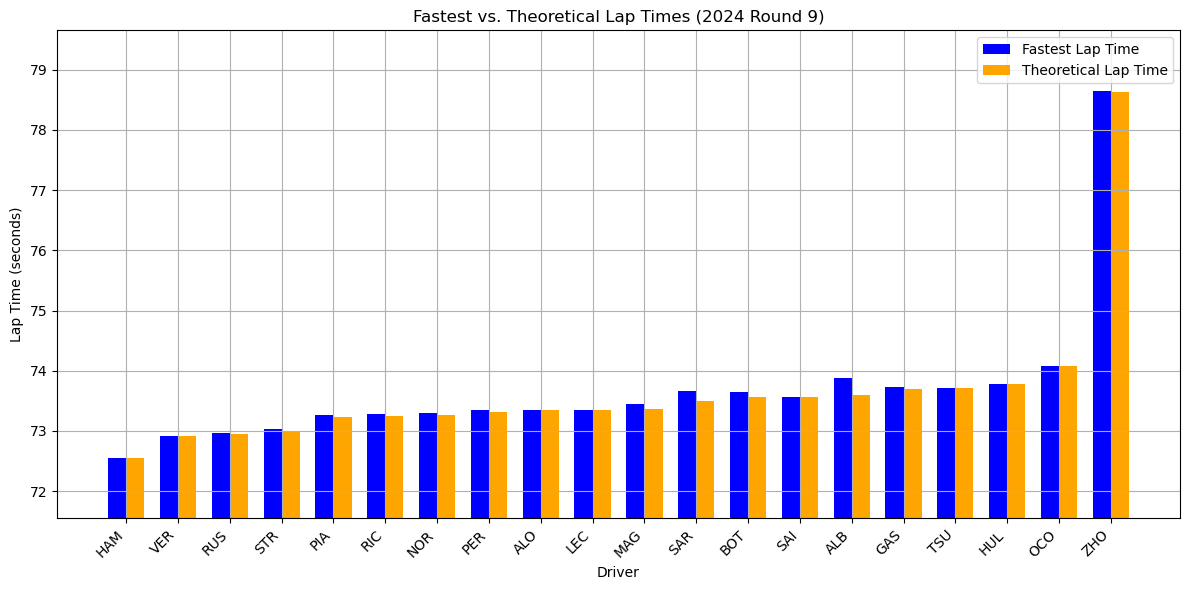

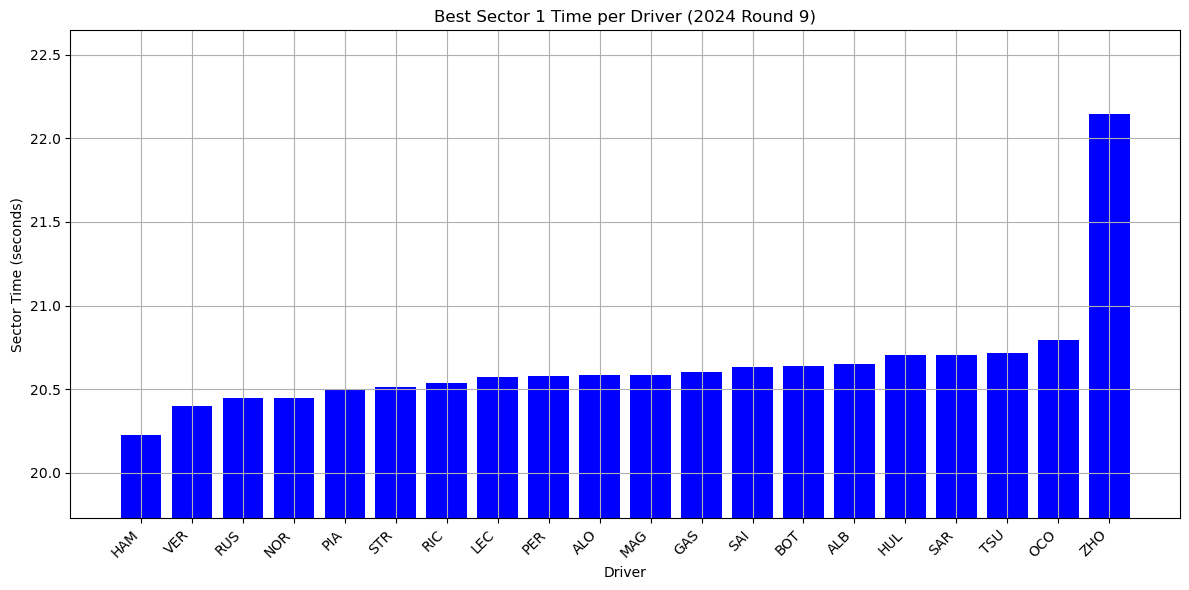

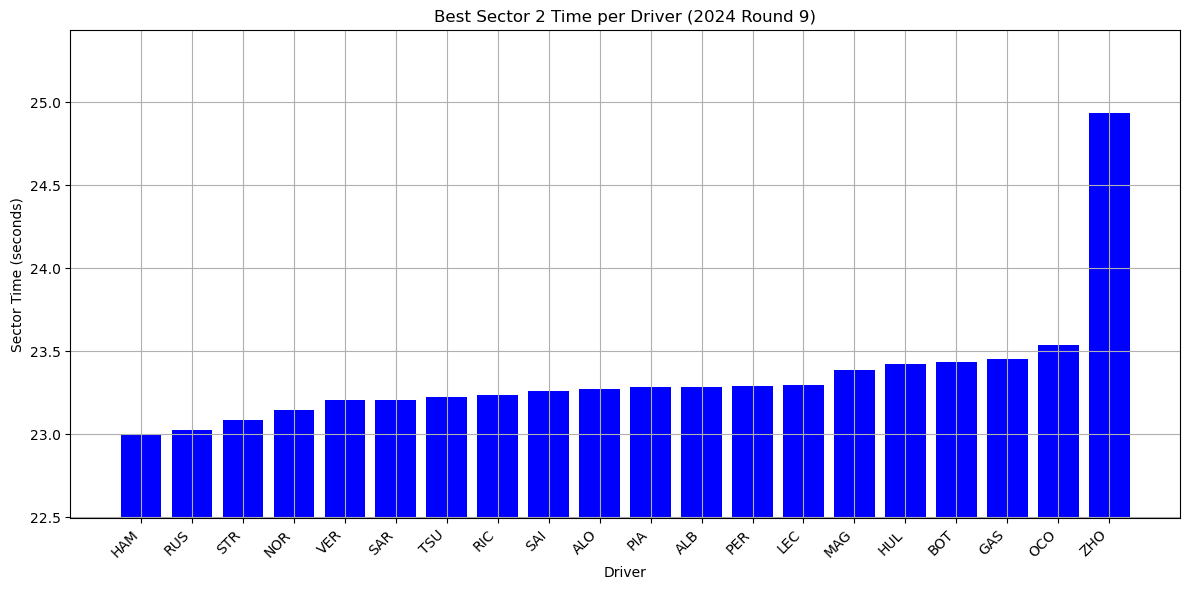

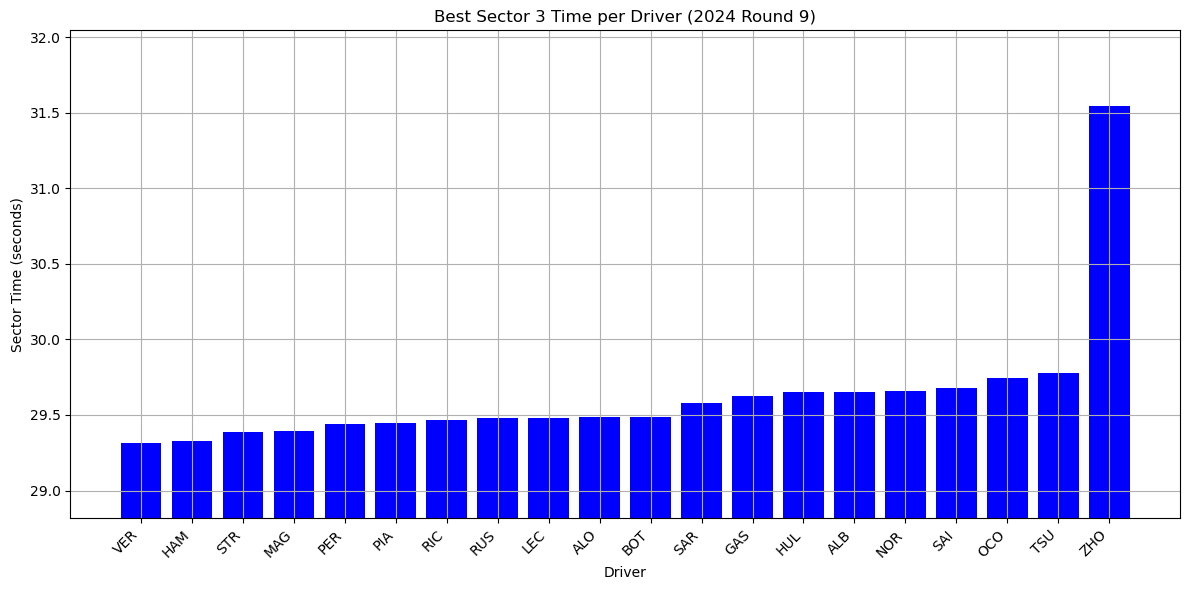

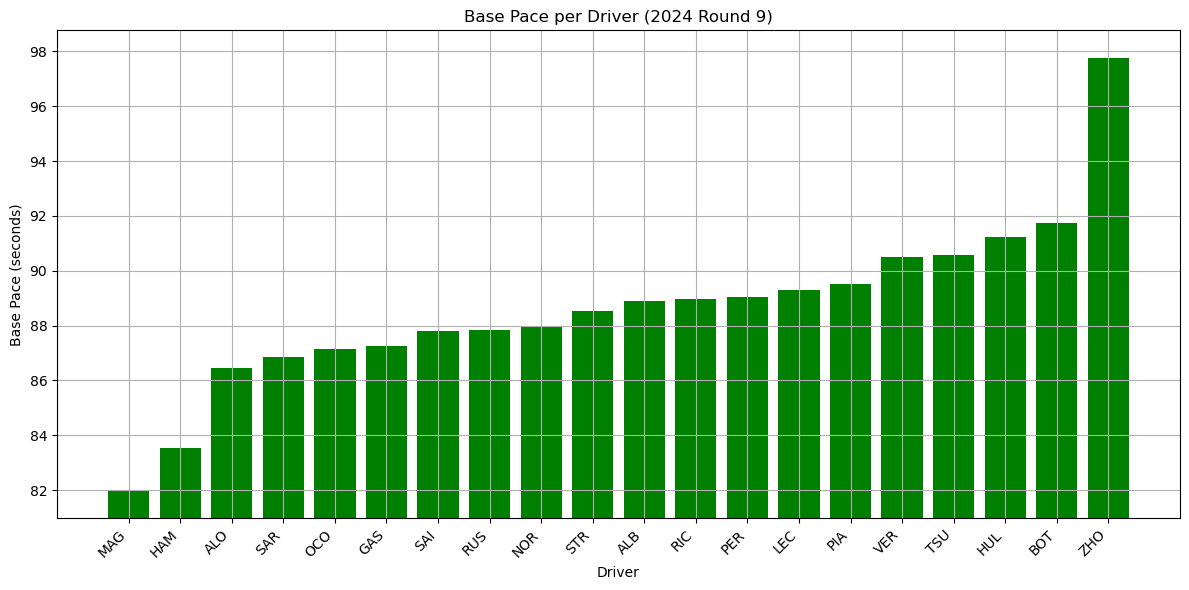

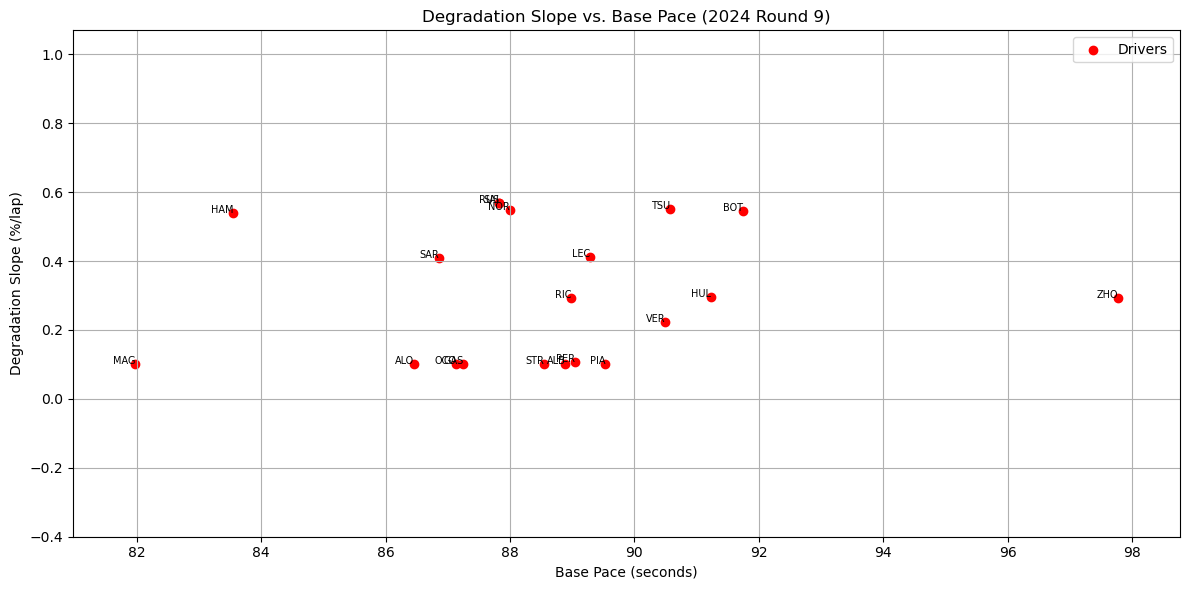

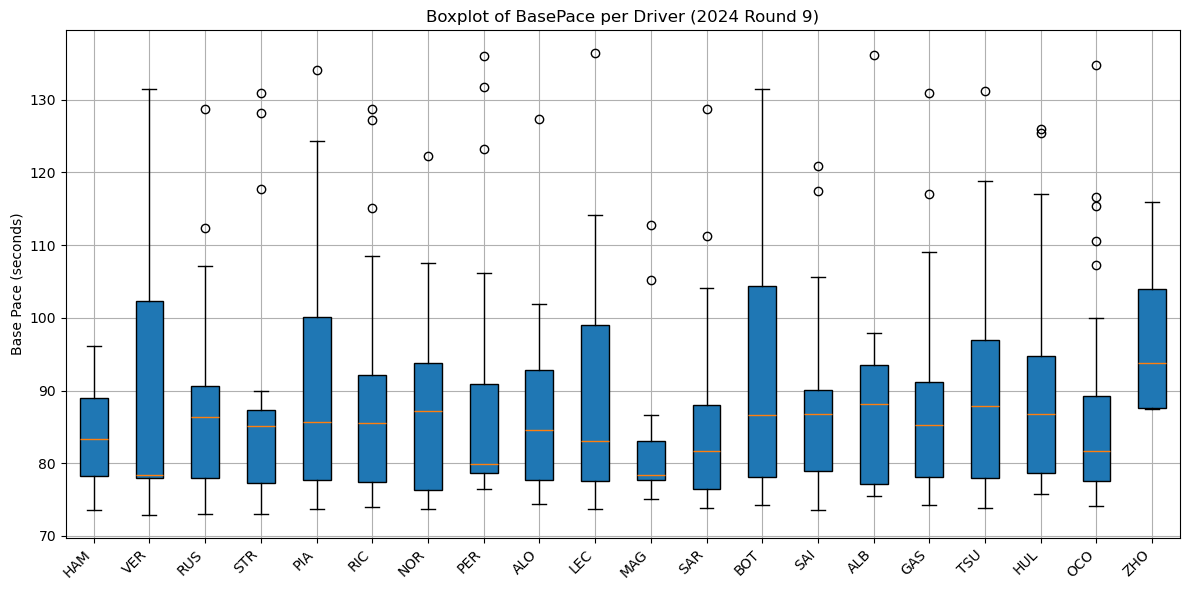


Debug: DegradationSlopeAdjusted values for plot: [0.22823323067256063, 0.0013264187476469957, 0.2557425982051511, -0.19552455352607617, -0.16092366271214947, -0.11597724589345829, 0.0385497765543798, -0.15065681269678988, -0.19552455352607617, 0.24625499951737018, -0.16092366271214947, 0.10259783170051684, 0.036585754880281096, 0.4527744228861187, -0.16092366271214947, -0.16092366271214947, 0.04084171445879747, 0.09399562239425174, -0.19552455352607617, 0.0]


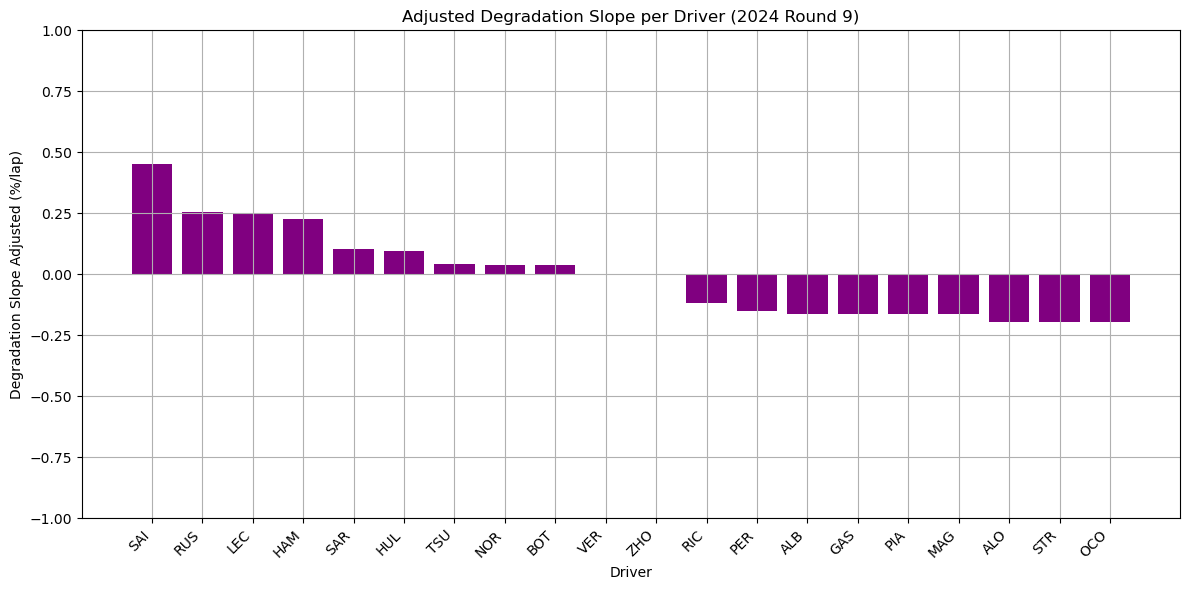


=== How to Read the Output ===
- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.
- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.
- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.
- **BasePace**: The average lap time on long runs (tyre life > 5 laps), reflecting race pace consistency.
- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation (dynamic tyre-age delta method, capped at 0.1% to 2% per lap), higher values indicate faster tyre wear. Calculated for the most used tyre compound per driver.
- **DegradationSlopeAdjusted**: The DegradationSlope adjusted relative to the compound-specific baseline (positive means worse than average

In [61]:
# Step 5: Unified Driver Performance Analysis
# Objective: Compute fastest lap times, best sector times, base pace, variance, degradation slopes, and theoretical fastest lap, with visualizations and a dynamic conclusion.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_driver_performance(cleaned_data, year, round_number, data_dir="raw_data"):
    """
    Compute fastest lap times, best sector times, base pace, variance, degradation slopes, and theoretical fastest lap.

    Args:
        cleaned_data (dict): Cleaned lap DataFrames from Step 4
        year (int): Race year (e.g., 2024)
        round_number (int): Round number (e.g., 3)
        data_dir (str): Directory for output files (default: "raw_data")

    Returns:
        pd.DataFrame: Driver performance metrics
    """
    # Update data_dir to match the format raw_data/{year}/R{round_number}/
    data_dir = os.path.join(data_dir, str(year), f"R{round_number}")

    # Combine all practice sessions
    all_laps = pd.concat([cleaned_data[session] for session in cleaned_data.keys()], ignore_index=True)

    # Convert time columns to seconds before any operations
    for col in ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']:
        if col in all_laps.columns:
            if pd.api.types.is_string_dtype(all_laps[col]):
                all_laps[col] = pd.to_timedelta(all_laps[col], errors='coerce').dt.total_seconds()
            elif pd.api.types.is_timedelta64_dtype(all_laps[col]):
                all_laps[col] = all_laps[col].dt.total_seconds()
            else:
                all_laps[col] = pd.to_numeric(all_laps[col], errors='coerce')

    # Compute fastest lap time per driver
    fastest_laps = all_laps.groupby('Driver').agg({
        'LapTime': 'min',
        'Team': 'first'
    }).reset_index()
    fastest_laps = fastest_laps.rename(columns={'LapTime': 'FastestLapTime'})

    # Compute best sector times per driver
    sector_performance = all_laps.groupby('Driver').agg({
        'Sector1Time': 'min',
        'Sector2Time': 'min',
        'Sector3Time': 'min'
    }).reset_index()

    # Compute theoretical fastest lap
    sector_performance['TheoreticalLapTime'] = sector_performance['Sector1Time'] + sector_performance['Sector2Time'] + sector_performance['Sector3Time']

    # Compute base pace and variance from long-run laps
    long_run_laps = all_laps[(all_laps['TyreLife'] > 5) & (all_laps['IsAccurate'])]  # Lowered to >5
    if not long_run_laps.empty:
        # Log the number of long-run laps per driver and tyre compounds used
        long_run_counts = long_run_laps.groupby('Driver').size()
        print("\nNumber of long-run laps per driver (TyreLife > 5):")
        for driver, count in long_run_counts.items():
            print(f"{driver}: {count} laps")
            # Log tyre compounds used
            tyre_counts = long_run_laps[long_run_laps['Driver'] == driver]['Compound'].value_counts()
            print(f"Tyre compounds for {driver}:")
            for compound, count in tyre_counts.items():
                print(f"  {compound}: {count} laps")

        # Flag drivers with low lap counts as potentially unreliable
        low_lap_drivers = long_run_counts[long_run_counts < 10].index.tolist()
        if low_lap_drivers:
            print(f"Warning: Low long-run lap counts (<10) for drivers: {', '.join(low_lap_drivers)}. BasePace and DegradationSlope may be unreliable.")

        # Ensure sufficient long-run laps per driver for degradation calculation
        insufficient_drivers = long_run_counts[long_run_counts < 5].index.tolist()
        if insufficient_drivers:
            print(f"Warning: Insufficient long-run laps (<5) for degradation calculation for drivers: {', '.join(insufficient_drivers)}. Using median proxy for these drivers.")

        # Filter outliers using relaxed IQR
        Q1 = long_run_laps['LapTime'].quantile(0.25)
        Q3 = long_run_laps['LapTime'].quantile(0.75)
        IQR = Q3 - Q1
        long_run_laps = long_run_laps[
            (long_run_laps['LapTime'] >= Q1 - 3 * IQR) &
            (long_run_laps['LapTime'] <= Q3 + 3 * IQR)
        ]
        base_pace = long_run_laps.groupby('Driver')['LapTime'].mean().reset_index()
        base_pace.columns = ['Driver', 'BasePace']
        pace_variance = long_run_laps.groupby('Driver')['LapTime'].std().reset_index()
        pace_variance.columns = ['Driver', 'LapTimeVar']

        # Compute average lap time per driver for normalization
        avg_lap_times = long_run_laps.groupby('Driver')['LapTime'].mean().reset_index()
        avg_lap_times.columns = ['Driver', 'AvgLapTime']

        # Compute degradation rate using dynamic tyre-age delta method with outlier removal
        degradation_rates = []
        for (driver, compound), group in long_run_laps.groupby(['Driver', 'Compound']):
            group = group.sort_values('TyreLife')
            if len(group) < 5:
                print(f"\nSkipping {driver} ({compound}) - Too few laps: {len(group)}")
                continue

            group['LapTimeSeconds'] = group['LapTime']  # Already in seconds from earlier conversion
            filtered_group = group[group['LapTimeSeconds'].notna()]

            if len(filtered_group) < 5:
                print(f"\nSkipping {driver} ({compound}) - Too few laps after filtering: {len(filtered_group)}")
                continue

            total_laps = len(filtered_group)
            early_laps = filtered_group.head(int(0.3 * total_laps))
            late_laps = filtered_group.tail(int(0.3 * total_laps))

            if len(early_laps) < 1 or len(late_laps) < 1:
                print(f"\nSkipping {driver} ({compound}) - Insufficient early or late laps")
                continue

            # Remove outliers within early and late laps using relaxed IQR
            early_Q1 = early_laps['LapTimeSeconds'].quantile(0.25)
            early_Q3 = early_laps['LapTimeSeconds'].quantile(0.75)
            early_IQR = early_Q3 - early_Q1
            early_laps = early_laps[
                (early_laps['LapTimeSeconds'] >= early_Q1 - 2 * early_IQR) &
                (early_laps['LapTimeSeconds'] <= early_Q3 + 2 * early_IQR)
            ]

            late_Q1 = late_laps['LapTimeSeconds'].quantile(0.25)
            late_Q3 = late_laps['LapTimeSeconds'].quantile(0.75)
            late_IQR = late_Q3 - late_Q1
            late_laps = late_laps[
                (late_laps['LapTimeSeconds'] >= late_Q1 - 2 * late_IQR) &
                (late_laps['LapTimeSeconds'] <= late_Q3 + 2 * late_IQR)
            ]

            if len(early_laps) < 1 or len(late_laps) < 1:
                print(f"\nSkipping {driver} ({compound}) - Insufficient early or late laps after outlier removal")
                continue

            avg_early = early_laps['LapTimeSeconds'].median()  # Use median to reduce outlier impact
            avg_late = late_laps['LapTimeSeconds'].median()
            total_life = filtered_group['TyreLife'].max() - filtered_group['TyreLife'].min()
            if total_life <= 2:
                continue

            # Calculate degradation rate in seconds per lap using tyre-age delta method
            degradation_rate = (avg_late - avg_early) / total_life  # seconds/lap
            degradation_rate = max(0, min(0.5, degradation_rate))  # Cap at 0 to 0.5 seconds/lap

            # Fallback to linear regression if the rate hits the cap
            if degradation_rate == 0 or degradation_rate == 0.5:
                tyre_lives = filtered_group['TyreLife'].values
                lap_times = filtered_group['LapTimeSeconds'].values
                if len(lap_times) > 2:
                    slope, _ = np.polyfit(tyre_lives, lap_times, 1)[:2]  # Linear fit
                    degradation_rate = max(0, min(0.5, slope))  # Cap at 0 to 0.5 seconds/lap

            degradation_rates.append({
                'Driver': driver,
                'Compound': compound,
                'DegradationRate': degradation_rate,
                'AvgEarlyLap': avg_early,
                'AvgLateLap': avg_late,
                'TotalTyreLife': total_life,
                'LapCountEarly': len(early_laps),
                'LapCountLate': len(late_laps),
                'TotalLaps': len(filtered_group)
            })

        if not degradation_rates:
            print("Warning: No valid degradation rates calculated.")
            deg_slope = pd.DataFrame(columns=['Driver', 'Compound', 'DegradationRate', 'AvgEarlyLap', 'AvgLateLap', 'TotalTyreLife', 'LapCountEarly', 'LapCountLate', 'TotalLaps'])
        else:
            deg_slope = pd.DataFrame(degradation_rates)
            # For each driver, select the compound with the most laps
            most_used_compound = deg_slope.groupby('Driver').apply(
                lambda x: x.loc[x['TotalLaps'].idxmax()],
                include_groups=False
            ).reset_index()
            deg_slope = most_used_compound[['Driver', 'Compound', 'DegradationRate']]
            deg_slope = deg_slope.rename(columns={'Compound': 'PrimaryCompound', 'DegradationRate': 'DegradationSlopeSec'})

        # Merge average lap times into deg_slope
        deg_slope = deg_slope.merge(avg_lap_times, on='Driver', how='left')
        # Convert DegradationSlope from seconds/lap to %/lap
        deg_slope['DegradationSlope'] = (deg_slope['DegradationSlopeSec'] / deg_slope['AvgLapTime']) * 100  # %/lap
        # Cap at 0.1% to 2% per lap
        deg_slope['DegradationSlope'] = deg_slope['DegradationSlope'].clip(lower=0.1, upper=2.0)

        # Calculate compound-specific baselines
        compound_baselines = deg_slope.groupby('PrimaryCompound')['DegradationSlope'].mean().to_dict()
        print("\nCompound-specific degradation baselines (%/lap):")
        for compound, baseline in compound_baselines.items():
            print(f"{compound}: {baseline:.2f}% per lap")

        # Adjust DegradationSlope relative to compound baseline (proportional scaling)
        deg_slope['CompoundBaseline'] = deg_slope['PrimaryCompound'].map(compound_baselines)
        median_degradation = deg_slope['DegradationSlope'].median()
        deg_slope['DegradationSlopeAdjusted'] = (deg_slope['DegradationSlope'] / deg_slope['CompoundBaseline']) * median_degradation - median_degradation
        deg_slope['DegradationSlopeAdjusted'] = deg_slope['DegradationSlopeAdjusted'].clip(lower=-1.0, upper=1.0)
    else:
        base_pace = pd.DataFrame({'Driver': fastest_laps['Driver'], 'BasePace': np.nan})
        pace_variance = pd.DataFrame({'Driver': fastest_laps['Driver'], 'LapTimeVar': np.nan})
        deg_slope = pd.DataFrame({'Driver': fastest_laps['Driver'], 'PrimaryCompound': 'Unknown', 'DegradationSlope': np.nan, 'DegradationSlopeAdjusted': np.nan})

    # Merge all metrics with outer joins to retain all drivers
    driver_performance = fastest_laps.merge(sector_performance, on='Driver', how='left')
    driver_performance = driver_performance.merge(base_pace, on='Driver', how='outer')
    driver_performance = driver_performance.merge(pace_variance, on='Driver', how='outer')
    driver_performance = driver_performance.merge(deg_slope[['Driver', 'PrimaryCompound', 'DegradationSlope', 'DegradationSlopeAdjusted']], on='Driver', how='left')

    # Compute dynamic fallbacks using data
    # For BasePace: Use median difference between BasePace and FastestLapTime
    valid_base_pace = driver_performance.dropna(subset=['BasePace', 'FastestLapTime'])
    if not valid_base_pace.empty:
        pace_offset = (valid_base_pace['BasePace'] - valid_base_pace['FastestLapTime']).median()
        if not np.isfinite(pace_offset):
            pace_offset = 5.0  # Fallback to 5 if median is invalid
        print(f"\nDynamic BasePace offset: {pace_offset:.2f} seconds")
    else:
        pace_offset = 5.0  # Fallback to 5 if no valid data
        print("\nNo valid BasePace data for dynamic offset; using fallback of 5.0 seconds")

    # For DegradationSlope: Use median of computed slopes as the default for all drivers
    median_degradation = deg_slope['DegradationSlope'].median()
    if not np.isfinite(median_degradation):
        median_degradation = 0.5  # Fallback to 0.5% if median is invalid
    print(f"Dynamic DegradationSlope default: {median_degradation:.2f}% per lap")

    # Apply median DegradationSlope to all drivers
    driver_performance['DegradationSlope'] = driver_performance['DegradationSlope'].fillna(median_degradation)
    driver_performance['DegradationSlopeAdjusted'] = driver_performance['DegradationSlopeAdjusted'].fillna(0.0)

    # For drivers with sufficient data, use calculated value if it's better (lower) than the median
    sufficient_data_mask = ~driver_performance['Driver'].isin(insufficient_drivers)
    calculated_better_mask = (deg_slope['DegradationSlope'].notna()) & (deg_slope['DegradationSlope'] < median_degradation)
    # Merge deg_slope with driver_performance to align indices
    deg_slope_aligned = deg_slope.set_index('Driver').reindex(driver_performance['Driver']).reset_index()
    driver_performance.loc[sufficient_data_mask & calculated_better_mask.reindex(driver_performance.index, fill_value=False), 'DegradationSlope'] = deg_slope_aligned.loc[sufficient_data_mask & calculated_better_mask.reindex(driver_performance.index, fill_value=False), 'DegradationSlope']
    driver_performance.loc[sufficient_data_mask & calculated_better_mask.reindex(driver_performance.index, fill_value=False), 'DegradationSlopeAdjusted'] = deg_slope_aligned.loc[sufficient_data_mask & calculated_better_mask.reindex(driver_performance.index, fill_value=False), 'DegradationSlopeAdjusted']

    # Apply fallbacks for drivers with insufficient long-run data
    mask = driver_performance['BasePace'].isna()
    driver_performance.loc[mask, 'BasePace'] = driver_performance.loc[mask, 'FastestLapTime'] + pace_offset
    driver_performance.loc[mask, 'LapTimeVar'] = 0.01 * driver_performance.loc[mask, 'BasePace']
    driver_performance.loc[mask, 'PrimaryCompound'] = 'Unknown'

    # Ensure realistic minimums
    driver_performance['DegradationSlope'] = driver_performance['DegradationSlope'].clip(lower=0.1, upper=2.0)
    driver_performance['LapTimeVar'] = driver_performance['LapTimeVar'].clip(lower=0.01 * driver_performance['BasePace'])

    # Sort by TheoreticalLapTime
    driver_performance = driver_performance.sort_values('TheoreticalLapTime')

    # Display table with sector times and theoretical lap time
    print("\nDriver Performance (sorted by TheoreticalLapTime):")
    display(driver_performance[['Driver', 'FastestLapTime', 'TheoreticalLapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'BasePace', 'DegradationSlope', 'DegradationSlopeAdjusted', 'PrimaryCompound', 'Team']])

    # Visualization 1: Bar chart comparing FastestLapTime and TheoreticalLapTime
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(driver_performance))
    # Calculate min and max times, excluding NaN and Inf
    valid_times = pd.concat([
        driver_performance['FastestLapTime'].dropna(),
        driver_performance['TheoreticalLapTime'].dropna()
    ])
    valid_times = valid_times[np.isfinite(valid_times)]
    if not valid_times.empty:
        min_time = valid_times.min() - 1
        max_time = valid_times.max() + 1
        plt.bar([i - bar_width/2 for i in index], driver_performance['FastestLapTime'], bar_width, label='Fastest Lap Time', color='blue')
        plt.bar([i + bar_width/2 for i in index], driver_performance['TheoreticalLapTime'], bar_width, label='Theoretical Lap Time', color='orange')
        plt.xlabel('Driver')
        plt.ylabel('Lap Time (seconds)')
        plt.title(f'Fastest vs. Theoretical Lap Times ({year} Round {round_number})')
        plt.xticks(index, driver_performance['Driver'], rotation=45, ha='right')
        plt.ylim(min_time, max_time)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid lap times for plotting Fastest vs. Theoretical Lap Times; skipping plot.")

    # Visualization 2: Separate bar charts for each sector time
    sectors = ['Sector1Time', 'Sector2Time', 'Sector3Time']
    sector_titles = ['Sector 1 Time', 'Sector 2 Time', 'Sector 3 Time']
    for sector, title in zip(sectors, sector_titles):
        plt.figure(figsize=(12, 6))
        sorted_sector = driver_performance.sort_values(sector)
        valid_sector_times = sorted_sector[sector].dropna()
        valid_sector_times = valid_sector_times[np.isfinite(valid_sector_times)]
        if not valid_sector_times.empty:
            min_sector = valid_sector_times.min() - 0.5
            max_sector = valid_sector_times.max() + 0.5
            plt.bar(sorted_sector['Driver'], sorted_sector[sector], color='blue')
            plt.xlabel('Driver')
            plt.ylabel('Sector Time (seconds)')
            plt.title(f'Best {title} per Driver ({year} Round {round_number})')
            plt.xticks(rotation=45, ha='right')
            plt.ylim(min_sector, max_sector)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: No valid {sector} values for plotting; skipping plot.")

    # Visualization 3: Bar chart for BasePace
    plt.figure(figsize=(12, 6))
    sorted_base_pace = driver_performance.sort_values('BasePace')
    valid_base_pace = sorted_base_pace['BasePace'].dropna()
    valid_base_pace = valid_base_pace[np.isfinite(valid_base_pace)]
    if not valid_base_pace.empty:
        min_pace = valid_base_pace.min() - 1
        max_pace = valid_base_pace.max() + 1
        plt.bar(sorted_base_pace['Driver'], sorted_base_pace['BasePace'], color='green')
        plt.xlabel('Driver')
        plt.ylabel('Base Pace (seconds)')
        plt.title(f'Base Pace per Driver ({year} Round {round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(min_pace, max_pace)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid BasePace values for plotting; skipping plot.")

    # Visualization 4: Scatter plot of DegradationSlope vs. BasePace
    plt.figure(figsize=(12, 6))
    valid_scatter_data = driver_performance.dropna(subset=['BasePace', 'DegradationSlope'])
    valid_scatter_data = valid_scatter_data[np.isfinite(valid_scatter_data['BasePace']) & np.isfinite(valid_scatter_data['DegradationSlope'])]
    if not valid_scatter_data.empty:
        min_slope = valid_scatter_data['DegradationSlope'].min() - 0.5
        max_slope = valid_scatter_data['DegradationSlope'].max() + 0.5
        min_pace_scatter = valid_scatter_data['BasePace'].min() - 1
        max_pace_scatter = valid_scatter_data['BasePace'].max() + 1
        plt.scatter(valid_scatter_data['BasePace'], valid_scatter_data['DegradationSlope'], c='red', label='Drivers')
        for i, driver in enumerate(valid_scatter_data['Driver']):
            plt.text(valid_scatter_data['BasePace'].iloc[i], valid_scatter_data['DegradationSlope'].iloc[i], driver, fontsize=7, ha='right')
        plt.xlabel('Base Pace (seconds)')
        plt.ylabel('Degradation Slope (%/lap)')
        plt.title(f'Degradation Slope vs. Base Pace ({year} Round {round_number})')
        plt.ylim(min_slope, max_slope)
        plt.xlim(min_pace_scatter, max_pace_scatter)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid DegradationSlope or BasePace values for scatter plot; skipping plot.")

    # Visualization 5: Boxplot for BasePace per Driver
    plt.figure(figsize=(12, 6))
    base_pace_boxes = [long_run_laps[long_run_laps['Driver'] == driver]['LapTime'].dropna() for driver in driver_performance['Driver']]
    if any(len(box) > 0 for box in base_pace_boxes):
        plt.boxplot(base_pace_boxes, tick_labels=driver_performance['Driver'], patch_artist=True)
        plt.ylabel('Base Pace (seconds)')
        plt.title(f'Boxplot of BasePace per Driver ({year} Round {round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid BasePace data for boxplot; skipping plot.")

    # Visualization 6: Bar chart for DegradationSlopeAdjusted per Driver
    print("\nDebug: DegradationSlopeAdjusted values for plot:", driver_performance['DegradationSlopeAdjusted'].tolist())
    plt.figure(figsize=(12, 6))
    sorted_deg_slope = driver_performance.sort_values('DegradationSlopeAdjusted', ascending=False)
    valid_deg_slope = sorted_deg_slope['DegradationSlopeAdjusted'].dropna()
    valid_deg_slope = valid_deg_slope[np.isfinite(valid_deg_slope)]
    if not valid_deg_slope.empty:
        plt.bar(sorted_deg_slope['Driver'], sorted_deg_slope['DegradationSlopeAdjusted'], color='purple')
        plt.xlabel('Driver')
        plt.ylabel('Degradation Slope Adjusted (%/lap)')
        plt.title(f'Adjusted Degradation Slope per Driver ({year} Round {round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(min(valid_deg_slope.min() - 0.5, -1.0), max(valid_deg_slope.max() + 0.5, 1.0))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid DegradationSlopeAdjusted values for plotting; skipping plot.")

    # Dynamic Conclusion and Guide
    print("\n=== How to Read the Output ===")
    print("- **FastestLapTime**: The fastest actual lap time achieved by each driver across practice sessions, indicating peak performance potential for qualifying.")
    print("- **TheoreticalLapTime**: The sum of the best sector times (Sector1Time + Sector2Time + Sector3Time), representing the theoretical fastest lap if the driver perfectly combines their best sectors.")
    print("- **Sector1Time, Sector2Time, Sector3Time**: The best times for each sector, showing strengths in different parts of the track.")
    print("- **BasePace**: The average lap time on long runs (tyre life > 5 laps), reflecting race pace consistency.")
    print("- **DegradationSlope**: The rate of lap time increase per lap due to tyre degradation (dynamic tyre-age delta method, capped at 0.1% to 2% per lap), higher values indicate faster tyre wear. Calculated for the most used tyre compound per driver.")
    print("- **DegradationSlopeAdjusted**: The DegradationSlope adjusted relative to the compound-specific baseline (positive means worse than average, negative means better).")
    print("- **PrimaryCompound**: The tyre compound used for the DegradationSlope calculation (most laps for that driver).")
    print("- **Boxplot of BasePace per Driver**: Shows the distribution of long-run lap times for each driver, with median, quartiles, and outliers indicating race pace consistency.")
    print("- **Bar Chart of DegradationSlopeAdjusted per Driver**: Displays the adjusted degradation slope values per driver, sorted from highest to lowest, highlighting tyre wear relative to the compound baseline.")

    print("\n=== Conclusion ===")
    print("This analysis provides insights into driver performance across practice sessions:")
    # Highlight fastest drivers
    fastest_driver = driver_performance.loc[driver_performance['FastestLapTime'].idxmin(), 'Driver']
    fastest_time = driver_performance['FastestLapTime'].min()
    print(f"- **Fastest Lap**: {fastest_driver} achieved the fastest lap time of {fastest_time:.2f} seconds, indicating strong qualifying potential.")

    # Highlight theoretical fastest lap
    theoretical_fastest_driver = driver_performance.loc[driver_performance['TheoreticalLapTime'].idxmin(), 'Driver']
    theoretical_fastest_time = driver_performance['TheoreticalLapTime'].min()
    print(f"- **Theoretical Fastest Lap**: {theoretical_fastest_driver} could theoretically achieve {theoretical_fastest_time:.2f} seconds by combining their best sector times.")

    # Highlight largest gap between fastest and theoretical lap
    driver_performance['LapTimeGap'] = driver_performance['FastestLapTime'] - driver_performance['TheoreticalLapTime']
    largest_gap_driver = driver_performance.loc[driver_performance['LapTimeGap'].idxmax(), 'Driver']
    largest_gap = driver_performance['LapTimeGap'].max()
    print(f"- **Largest Gap**: {largest_gap_driver} has the largest gap between their fastest lap and theoretical lap ({largest_gap:.2f} seconds), indicating inconsistency across sectors.")

    # Highlight base pace anomalies dynamically
    base_pace_median = driver_performance['BasePace'].median()
    base_pace_q1 = driver_performance['BasePace'].quantile(0.25)
    base_pace_q3 = driver_performance['BasePace'].quantile(0.75)
    base_pace_iqr = base_pace_q3 - base_pace_q1
    base_pace_outliers_low = driver_performance[driver_performance['BasePace'] < base_pace_q1 - 1.5 * base_pace_iqr]['Driver'].tolist()
    if base_pace_outliers_low:
        for driver in base_pace_outliers_low:
            driver_base_pace = driver_performance[driver_performance['Driver'] == driver]['BasePace'].iloc[0]
            print(f"- **Base Pace Anomaly**: {driver}’s base pace ({driver_base_pace:.2f} seconds) is significantly lower than the median ({base_pace_median:.2f} seconds), possibly due to a setup optimized for short runs or insufficient long-run data. Verify with additional laps.")

    # Highlight race pace insights from boxplot
    base_pace_outliers = driver_performance[(driver_performance['BasePace'] < base_pace_q1 - 1.5 * base_pace_iqr) |
                                           (driver_performance['BasePace'] > base_pace_q3 + 1.5 * base_pace_iqr)]['Driver'].tolist()
    print(f"- **Race Pace Insight**: The median base pace is {base_pace_median:.2f} seconds, with outliers including {', '.join(base_pace_outliers) if base_pace_outliers else 'none'}, indicating potential inconsistency or unique setups.")

    # Highlight tyre degradation insights dynamically
    deg_slope_median = driver_performance['DegradationSlope'].median()
    deg_slope_q1 = driver_performance['DegradationSlope'].quantile(0.25)
    deg_slope_q3 = driver_performance['DegradationSlope'].quantile(0.75)
    deg_slope_iqr = deg_slope_q3 - deg_slope_q1
    deg_slope_outliers = driver_performance[(driver_performance['DegradationSlope'] < deg_slope_q1 - 1.5 * deg_slope_iqr) |
                                           (driver_performance['DegradationSlope'] > deg_slope_q3 + 1.5 * deg_slope_iqr)]['Driver'].tolist()
    print(f"- **Tyre Degradation Insight**: The median degradation slope is {deg_slope_median:.2f}% per lap, with outliers including {', '.join(deg_slope_outliers) if deg_slope_outliers else 'none'}, suggesting potential tyre wear issues.")

    print("\n**Next Steps**: Compare these metrics with telemetry data (Step 6) to assess car setup, sandbagging analysis (Step 7) for hidden pace, and track characteristics (Step 9) to understand track-specific advantages.")

    # Save to CSV
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_driver_performance.csv")
    driver_performance.to_csv(output_file, index=False)
    print(f"Saved driver performance to {output_file}")

    return driver_performance

# Standalone execution for debugging (runs only if cell is executed directly)
if 'cleaned_data' in globals() and 'target_info' in globals():
    driver_performance_df = compute_driver_performance(cleaned_data, year=target_info['year'], round_number=target_info['round'])
else:
    print("Warning: cleaned_data and/or target_info not found. Run Cells 2 and 4 first for standalone execution.")

# Why: Analyzes driver performance metrics (fastest lap, sectors, base pace, degradation) for prediction.
# How to Read: Displays a table of metrics, visualizations (bar charts, scatter, boxplot), and a dynamic conclusion.
# Expected Inputs: cleaned_data from Step 4, year and round_number from target_info
# Expected Outputs: Table, 6 visualizations, conclusion, CSV file
# Data Exported: driver_performance.csv in raw_data/{year}/R{round_number}/ directory

2025-03-19 11:34:14,807 - INFO - Loading Practice 1 from cache or downloading for telemetry...
2025-03-19 11:34:25,955 - INFO - Loading Practice 2 from cache or downloading for telemetry...
2025-03-19 11:34:37,735 - INFO - Loading Practice 3 from cache or downloading for telemetry...



Telemetry Metrics (Top 10 by Max Speed):


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
14,RUS,327.333333,49.045946,0.217064,Mercedes
16,SAR,326.666667,46.182828,0.228125,Williams
13,RIC,324.000000,51.075449,0.205217,RB
10,OCO,323.000000,54.895685,0.209815,Alpine
12,PIA,322.333333,0.048733,0.213671,McLaren
8,MAG,322.000000,51.455621,0.215863,Haas F1 Team
1,ALO,321.666667,7.462010,0.216168,Aston Martin
11,PER,321.333333,51.665117,0.217066,Red Bull Racing
17,STR,320.666667,0.325166,0.203906,Aston Martin
18,TSU,320.333333,49.076211,0.208388,RB


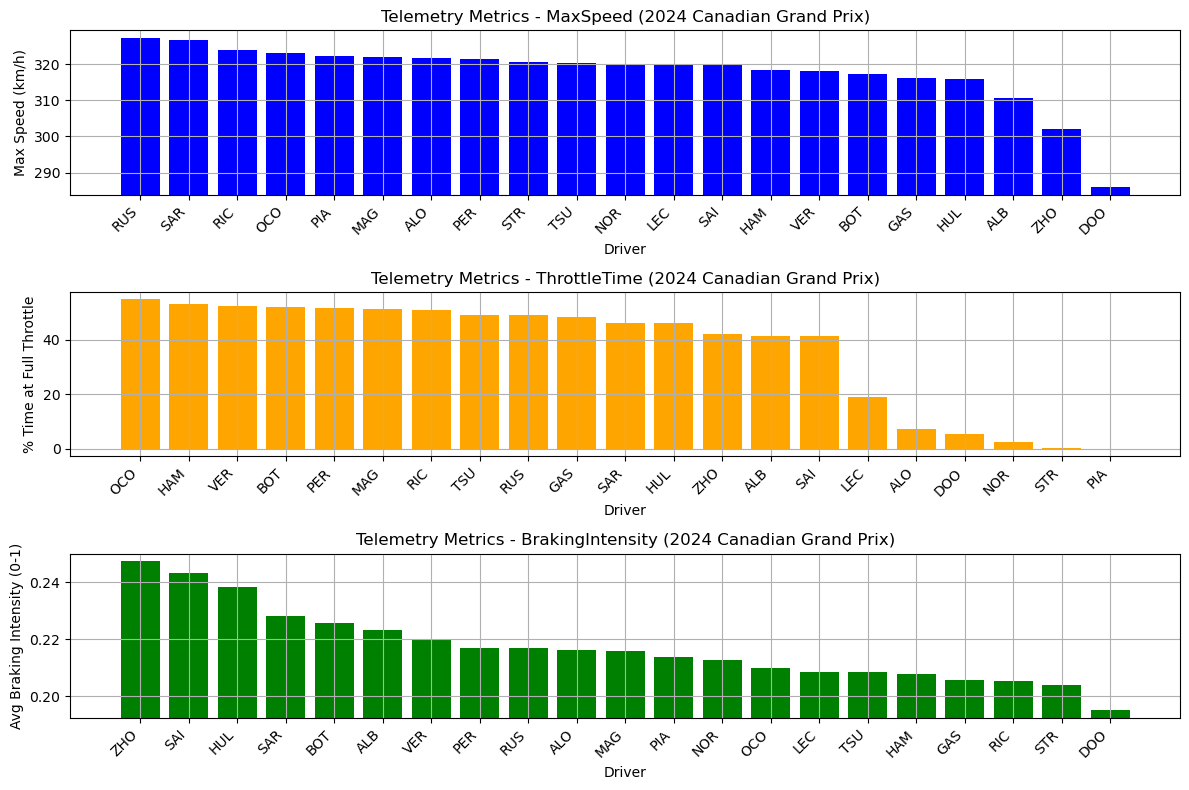


=== Evaluation and Conclusion ===
Telemetry metrics for 2024 Round 9 - Canadian Grand Prix provide insights into car setup and driver behavior:
- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.
  - Top Performer: RUS with 327.33 km/h, indicating strong straight-line speed.
  - Lowest: DOO with 286.00 km/h, possibly prioritizing downforce for cornering over top speed.
- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.
  - Top Performer: OCO with 54.90% time at full throttle, suggesting an aggressive approach or high-speed setup.
  - Lowest: PIA with 0.05% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.
- **Braking Int

In [62]:
# Step 6 - Assess Telemetry Metrics
# Objective: Analyze telemetry (top speed, throttle time, braking) to infer car setup and driver style, visualizing as bar charts.

import pandas as pd
import matplotlib.pyplot as plt
import os
import fastf1
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def analyze_telemetry_metrics(config):
    """
    Analyze telemetry metrics (top speed, throttle time, braking) to infer car setup and driver style.

    Args:
        config (dict): Configuration dictionary containing:
            - 'year': The race year (e.g., 2024)
            - 'round': The round number (e.g., 3)
            - 'session_types': List of session labels (default: ['Practice 1', 'Practice 2', 'Practice 3'])
            - 'data_dir': Directory for raw data (default: "raw_data")
            - 'event_name': Event name (optional, for context)

    Returns:
        pd.DataFrame: DataFrame with averaged telemetry metrics
    """
    # Extract configuration
    year = config.get('year')
    round_number = config.get('round')  # Matches target_info key
    session_labels = config.get('session_types', ['Practice 1', 'Practice 2', 'Practice 3'])
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")  # Updated to match project structure
    event_name = config.get('event_name', "Unknown Event")

    # Set base directory dynamically
    BASE_DIR = os.getcwd()  # Jupyter-friendly, avoids __file__ issues in notebooks

    # Enable caching and set cache directory
    cache_dir = os.path.join(BASE_DIR, "cache")
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    fastf1.Cache.enable_cache(cache_dir)

    # Load raw session data for telemetry
    telemetry_metrics = []
    for session_label in session_labels:
        logger.info(f"Loading {session_label} from cache or downloading for telemetry...")
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(laps=True, telemetry=True, weather=True)  # Load full session data without force_load
            laps = session.laps

            # Extract telemetry for a sample lap per driver (e.g., fastest lap)
            driver_metrics = {}
            for driver in laps['Driver'].unique():
                driver_laps = laps[laps['Driver'] == driver]
                fastest_lap = driver_laps.loc[driver_laps['LapTime'].idxmin()]
                if not pd.isna(fastest_lap['LapTime']):
                    telemetry = fastest_lap.get_telemetry()
                    # Metrics: Max Speed, % Time at Full Throttle, Avg Braking Intensity
                    max_speed = telemetry['Speed'].max()
                    throttle_time = (telemetry['Throttle'] == 100).mean() * 100  # % time at full throttle
                    braking_intensity = telemetry['Brake'].mean()  # Avg brake application (0-1)
                    driver_metrics[driver] = {
                        'Driver': driver,
                        'MaxSpeed': max_speed,
                        'ThrottleTime': throttle_time,
                        'BrakingIntensity': braking_intensity,
                        'Session': session_label
                    }

            # Convert to DataFrame and append
            session_df = pd.DataFrame.from_dict(driver_metrics, orient='index')
            telemetry_metrics.append(session_df)
        except Exception as e:
            logger.warning(f"Error loading {session_label}: {e}. Skipping session.")
            continue

    if not telemetry_metrics:
        logger.error("No telemetry data available to process.")
        return pd.DataFrame()

    # Combine and average metrics across sessions
    all_telemetry = pd.concat(telemetry_metrics, ignore_index=True)
    overall_telemetry = all_telemetry.groupby('Driver').mean(numeric_only=True).reset_index()

    # Merge with team info (from FP3 raw data)
    fp3_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_Practice_3_laps.csv")  # Updated to match Step 3 naming
    if os.path.exists(fp3_file):
        fp3_data = pd.read_csv(fp3_file)
        team_info = fp3_data[['Driver', 'Team']].drop_duplicates()
        overall_telemetry = overall_telemetry.merge(team_info, on='Driver', how='left')
    else:
        logger.warning(f"Warning: {fp3_file} not found. Team info will be incomplete.")
        overall_telemetry['Team'] = 'Unknown'  # Default value if no team data

    # Display table
    print("\nTelemetry Metrics (Top 10 by Max Speed):")
    display(overall_telemetry.sort_values('MaxSpeed', ascending=False).head(10))

    # Visualization with bar charts
    plt.figure(figsize=(12, 8))
    metrics = ['MaxSpeed', 'ThrottleTime', 'BrakingIntensity']
    titles = ['Max Speed (km/h)', '% Time at Full Throttle', 'Avg Braking Intensity (0-1)']
    colors = ['blue', 'orange', 'green']

    for i, (metric, title, color) in enumerate(zip(metrics, titles, colors), 1):
        plt.subplot(3, 1, i)
        # For ThrottleTime, filter out drivers with 0% (invalid data)
        if metric == 'ThrottleTime':
            plot_data = overall_telemetry[overall_telemetry['ThrottleTime'] > 0]
        else:
            plot_data = overall_telemetry
        sorted_data = plot_data.sort_values(metric, ascending=False)
        plt.bar(sorted_data['Driver'], sorted_data[metric], color=color)

        # Adjust y-axis limits for better readability
        y_min = sorted_data[metric].min()
        y_max = sorted_data[metric].max()
        y_range = y_max - y_min
        plt.ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

        plt.xlabel('Driver')
        plt.ylabel(title)
        plt.title(f'Telemetry Metrics - {metric} ({year} {event_name})')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluation and Conclusion
    print("\n=== Evaluation and Conclusion ===")
    print(f"Telemetry metrics for {year} Round {round_number} - {event_name} provide insights into car setup and driver behavior:")

    # Identify top performers and outliers
    top_speed_driver = overall_telemetry.loc[overall_telemetry['MaxSpeed'].idxmax(), 'Driver']
    top_speed_value = overall_telemetry['MaxSpeed'].max()
    low_speed_driver = overall_telemetry.loc[overall_telemetry['MaxSpeed'].idxmin(), 'Driver']
    low_speed_value = overall_telemetry['MaxSpeed'].min()

    # Filter out invalid ThrottleTime for evaluation
    valid_throttle = overall_telemetry[overall_telemetry['ThrottleTime'] > 0]
    if not valid_throttle.empty:
        top_throttle_driver = valid_throttle.loc[valid_throttle['ThrottleTime'].idxmax(), 'Driver']
        top_throttle_value = valid_throttle['ThrottleTime'].max()
        low_throttle_driver = valid_throttle.loc[valid_throttle['ThrottleTime'].idxmin(), 'Driver']
        low_throttle_value = valid_throttle['ThrottleTime'].min()
    else:
        top_throttle_driver = "N/A"
        top_throttle_value = "N/A"
        low_throttle_driver = "N/A"
        low_throttle_value = "N/A"

    top_braking_driver = overall_telemetry.loc[overall_telemetry['BrakingIntensity'].idxmax(), 'Driver']
    top_braking_value = overall_telemetry['BrakingIntensity'].max()
    low_braking_driver = overall_telemetry.loc[overall_telemetry['BrakingIntensity'].idxmin(), 'Driver']
    low_braking_value = overall_telemetry['BrakingIntensity'].min()

    # Generic insights with dynamic data
    print("- **Max Speed**: Indicates straight-line performance. Higher values suggest setups optimized for speed, which can be advantageous on tracks with long straights or high-speed sections.")
    print(f"  - Top Performer: {top_speed_driver} with {top_speed_value:.2f} km/h, indicating strong straight-line speed.")
    print(f"  - Lowest: {low_speed_driver} with {low_speed_value:.2f} km/h, possibly prioritizing downforce for cornering over top speed.")

    print("- **Throttle Time**: Reflects driving style or setup focus. High percentages indicate aggressive driving or setups designed for sustained high-speed performance, while low values may suggest a focus on technical corners or conservative driving.")
    if not valid_throttle.empty:
        print(f"  - Top Performer: {top_throttle_driver} with {top_throttle_value:.2f}% time at full throttle, suggesting an aggressive approach or high-speed setup.")
        print(f"  - Lowest: {low_throttle_driver} with {low_throttle_value:.2f}% time at full throttle, which may indicate a setup favoring cornering or potential sandbagging.")
    else:
        print("  - Note: Throttle time data is missing or invalid for all drivers, which may indicate telemetry issues. Investigate data collection for accuracy.")

    # Note missing throttle time drivers
    missing_throttle = overall_telemetry[overall_telemetry['ThrottleTime'] == 0]['Driver'].tolist()
    if missing_throttle:
        print(f"  - Missing Throttle Time: The following drivers have 0% throttle time, which may indicate telemetry errors: {', '.join(missing_throttle)}. These drivers are excluded from the throttle time chart.")

    print("- **Braking Intensity**: Measures average brake application (0-1). Higher values indicate heavier braking, often associated with late-braking techniques, while lower values suggest smoother driving, which can be advantageous in technical sections.")
    print(f"  - Top Performer: {top_braking_driver} with an intensity of {top_braking_value:.3f}, potentially excelling in late braking into corners.")
    print(f"  - Lowest: {low_braking_driver} with an intensity of {low_braking_value:.3f}, indicating a smoother braking style that may preserve tyre life.")

    # Combined interpretation
    print("\n**Combined Interpretation**:")
    print("Drivers with high max speed and throttle time are likely to perform well in qualifying, especially on tracks favoring straight-line speed. Those with balanced braking intensity may excel in races, particularly on circuits with technical corners where tyre management and cornering stability are key.")
    print("Look for outliers: Drivers with unusually low throttle time or high braking intensity may be sandbagging or using setups that prioritize race pace over qualifying performance. Correlate these metrics with lap times (Step 5) and sandbagging analysis (Step 7) to identify potential hidden pace.")

    # Save table
    output_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_telemetry_metrics.csv")
    overall_telemetry.to_csv(output_file, index=False)
    print(f"Saved telemetry metrics to {output_file}")

    return overall_telemetry

# Example usage with dynamic target_info
telemetry_metrics_df = analyze_telemetry_metrics(target_info)

# Why: Telemetry reveals car setup (speed, downforce) and driver aggression, key for pole and race.
# How to Read: Higher Max Speed = straight-line strength. High Throttle = aggressive driving. Moderate Braking = technical skill.
# Expected Inputs: target_info with year, round, session_types, event_name
# Expected Outputs: Table of metrics, bar charts, evaluation, saved CSV
# Data Exported: {year}_R{round}_telemetry_metrics.csv in raw_data/{year}/R{round_number}/ directory

2025-03-19 12:01:23,472 - INFO - Base directory: C:\data\Dropbox\dev\F1



Potential Sandbaggers (Sorted by PredictionDiscrepancy):


,Driver,FastestLapTime,Team,MaxSpeed,ThrottleTime,ExpectedLapTime,LapTimeDiscrepancy,PredictedLapTime,PredictionDiscrepancy,SpeedRank,LapTimeRank,SandbagFlag
11,SAR,73.663,Williams,326.666667,46.182828,73.492,0.171,72.460020,1.202980,2.0,14.0,True
18,OCO,74.075,Alpine,323.000000,54.895685,74.075,0.000,73.069756,1.005244,4.0,19.0,True
2,RUS,72.957,Mercedes,327.333333,49.045946,72.950,0.007,72.349159,0.607841,1.0,3.0,True
5,RIC,73.279,RB,324.000000,51.075449,73.242,0.037,72.903465,0.375535,3.0,6.0,True
10,MAG,73.439,Haas F1 Team,322.000000,51.455621,73.367,0.072,73.236048,0.202952,6.0,11.0,True
16,TSU,73.716,RB,320.333333,49.076211,73.716,0.000,73.513201,0.202799,10.0,15.0,True


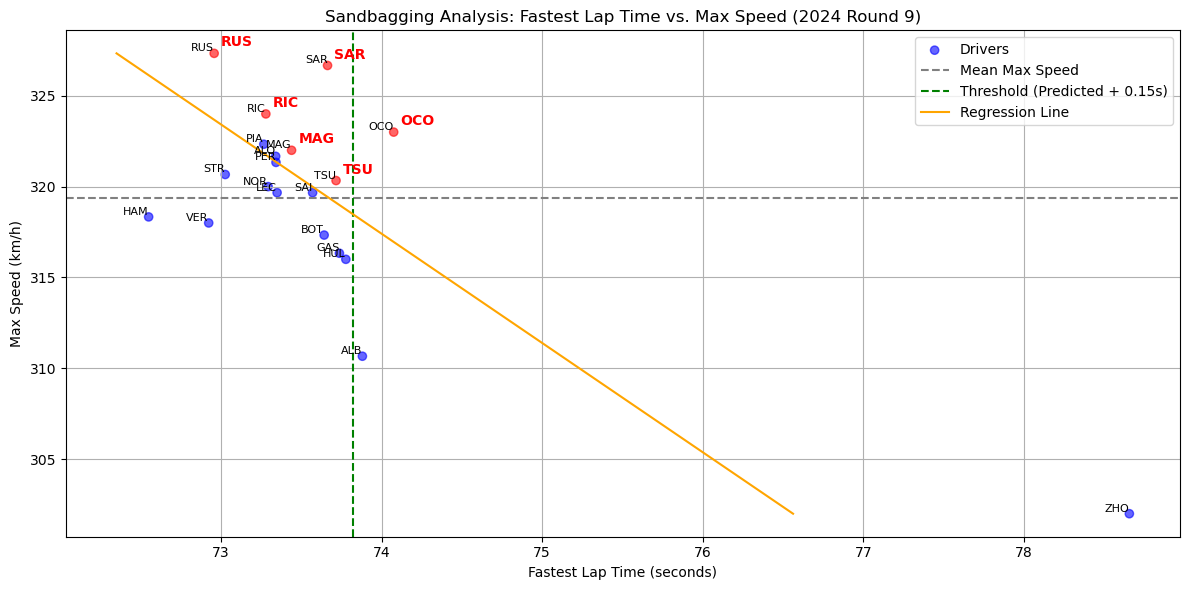

Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_sandbag_analysis.csv


In [63]:
# Step 7: Sandbagging Analysis (Updated to Use Driver Performance Data)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

if not logger.handlers:
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

def investigate_sandbagging(config):
    """
    Detect teams hiding pace by comparing lap times to telemetry metrics.

    Args:
        config (dict): Configuration dictionary containing:
            - 'year': The race year (e.g., 2024)
            - 'round': The round number (e.g., 3)
            - 'data_dir': Directory for raw data (default: "raw_data")
            - 'sandbag_threshold': Discrepancy threshold for sandbagging (default: 0.15 seconds)

    Returns:
        pd.DataFrame: Sandbagging analysis results
    """
    year = config.get('year')
    round_number = config.get('round')  # Matches target_info
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")  # Updated to match project structure
    sandbag_threshold = config.get('sandbag_threshold', 0.15)

    BASE_DIR = os.getcwd()  # Jupyter-friendly, avoids __file__ issues
    logger.info(f"Base directory: {BASE_DIR}")

    # Load data
    driver_performance_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_driver_performance.csv")
    telemetry_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_telemetry_metrics.csv")
    if not os.path.exists(driver_performance_file):
        logger.error(f"Driver performance file not found: {driver_performance_file}")
        return pd.DataFrame()
    if not os.path.exists(telemetry_file):
        logger.error(f"Telemetry metrics file not found: {telemetry_file}")
        return pd.DataFrame()

    driver_performance = pd.read_csv(driver_performance_file)
    telemetry_metrics = pd.read_csv(telemetry_file)

    # Merge data
    sandbag_analysis = driver_performance[['Driver', 'FastestLapTime', 'Team']].merge(
        telemetry_metrics[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left'
    )
    # Check for NaN values in telemetry metrics
    if sandbag_analysis[['MaxSpeed', 'ThrottleTime']].isna().any().any():
        logger.warning("NaN values found in telemetry metrics. Filling with median values.")
        sandbag_analysis['MaxSpeed'] = sandbag_analysis['MaxSpeed'].fillna(telemetry_metrics['MaxSpeed'].median())
        sandbag_analysis['ThrottleTime'] = sandbag_analysis['ThrottleTime'].fillna(telemetry_metrics['ThrottleTime'].median())

    sandbag_analysis['ExpectedLapTime'] = driver_performance['Sector1Time'] + driver_performance['Sector2Time'] + driver_performance['Sector3Time']
    sandbag_analysis['LapTimeDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['ExpectedLapTime']

    # Predict FastestLapTime from MaxSpeed using linear regression
    X = sandbag_analysis[['MaxSpeed']].values
    y = sandbag_analysis['FastestLapTime'].values
    reg = LinearRegression().fit(X, y)
    sandbag_analysis['PredictedLapTime'] = reg.predict(X)
    sandbag_analysis['PredictionDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['PredictedLapTime']
    sandbag_analysis['SpeedRank'] = sandbag_analysis['MaxSpeed'].rank(ascending=False)
    sandbag_analysis['LapTimeRank'] = sandbag_analysis['FastestLapTime'].rank()

    # New sandbagging logic: Flag drivers with high MaxSpeed (above mean) and FastestLapTime exceeding PredictedLapTime + threshold
    mean_max_speed = sandbag_analysis['MaxSpeed'].mean()
    sandbag_analysis['SandbagFlag'] = (sandbag_analysis['MaxSpeed'] > mean_max_speed) & (sandbag_analysis['PredictionDiscrepancy'] > sandbag_threshold)

    # Display potential sandbaggers
    print("\nPotential Sandbaggers (Sorted by PredictionDiscrepancy):")
    display(sandbag_analysis[sandbag_analysis['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False))

    # Visualization: Scatter plot of FastestLapTime vs. MaxSpeed with sandbaggers highlighted
    plt.figure(figsize=(12, 6))
    colors = ['blue' if not flag else 'red' for flag in sandbag_analysis['SandbagFlag']]
    scatter = plt.scatter(sandbag_analysis['FastestLapTime'], sandbag_analysis['MaxSpeed'], c=colors, label='Drivers', alpha=0.6)
    plt.axhline(y=mean_max_speed, color='gray', linestyle='--', label='Mean Max Speed')
    plt.axvline(x=sandbag_analysis['PredictedLapTime'].mean() + sandbag_threshold, color='green', linestyle='--', label=f'Threshold (Predicted + {sandbag_threshold}s)')
    # Plot regression line
    x_range = np.array([[sandbag_analysis['MaxSpeed'].min()], [sandbag_analysis['MaxSpeed'].max()]])
    y_pred = reg.predict(x_range)
    plt.plot(y_pred, x_range, color='orange', linestyle='-', label='Regression Line')
    for i, row in sandbag_analysis.iterrows():
        plt.text(row['FastestLapTime'], row['MaxSpeed'], row['Driver'], fontsize=8, ha='right', va='bottom')
        if row['SandbagFlag']:
            plt.annotate(row['Driver'], (row['FastestLapTime'], row['MaxSpeed']), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', weight='bold')
    plt.xlabel('Fastest Lap Time (seconds)')
    plt.ylabel('Max Speed (km/h)')
    plt.title(f'Sandbagging Analysis: Fastest Lap Time vs. Max Speed ({year} Round {round_number})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save results
    output_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_sandbag_analysis.csv")
    sandbag_analysis.to_csv(output_file, index=False)
    print(f"Saved sandbag analysis to {output_file}")

    return sandbag_analysis

# Example usage with dynamic target_info
sandbag_analysis_df = investigate_sandbagging(target_info)

# Why: Detects teams hiding pace by comparing lap times to telemetry, aiding race prediction.
# How to Read: High PredictionDiscrepancy with high MaxSpeed flags sandbagging. Red dots on scatter plot highlight suspects.
# Expected Inputs: driver_performance.csv, telemetry_metrics.csv from prior steps
# Expected Outputs: Table of sandbaggers, scatter plot, saved CSV
# Data Exported: {year}_R{round_number}_sandbag_analysis.csv in raw_data/{year}/R{round_number}/ directory

Average lap time for Practice 1: 92.011 seconds (±5.481)
Average lap time for Practice 2: 90.747 seconds (±14.262)
Average lap time for Practice 3: 87.664 seconds (±16.576)
Loading weather for Practice 1 from FastF1...
Available weather columns for Practice 1: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Practice 2 from FastF1...
Available weather columns for Practice 2: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Loading weather for Practice 3 from FastF1...
Available weather columns for Practice 3: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,92.010741,5.480808,58
1,Practice 2,90.747054,14.262214,315
2,Practice 3,87.664076,16.575574,407



Average Weather Conditions Across Sessions:


WeatherType,AirTemp,Humidity,Rainfall,TrackTemp
Session,,,,
Practice 1,18.237179,83.576923,0.179487,28.682051
Practice 2,18.996250,68.500000,0.887500,25.546250
Practice 3,20.854321,61.925926,0.000000,36.400000



Correlation between TrackTemp and AvgLapTime: -0.841


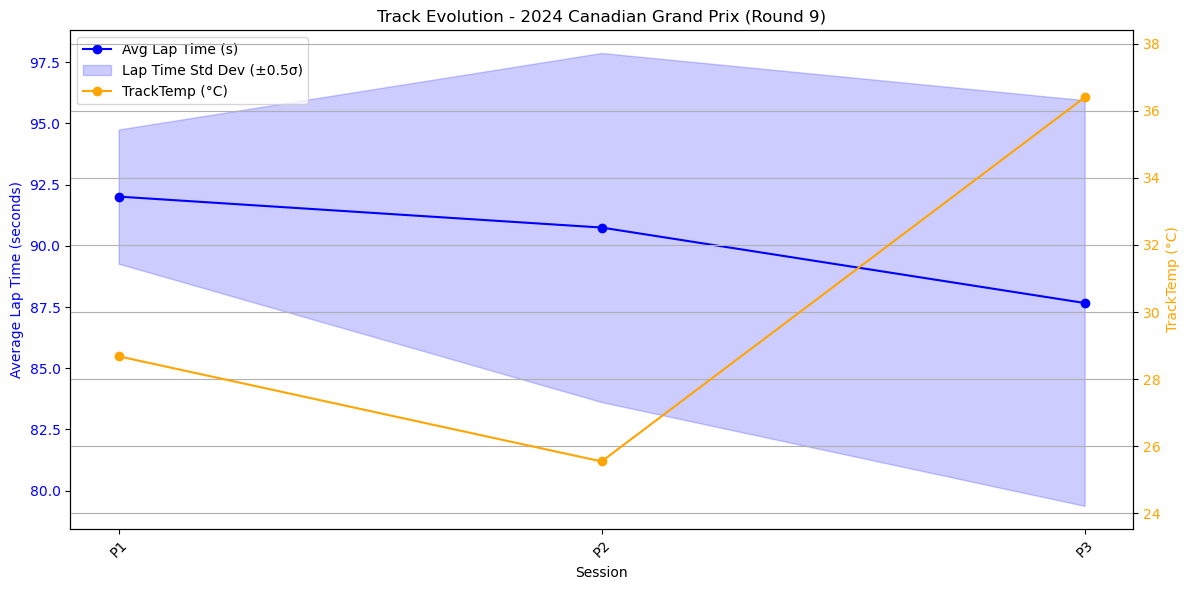

Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_evolution.csv


In [64]:
# Step 8 - Evaluate Track Evolution and Weather Impact
import pandas as pd
import matplotlib.pyplot as plt
import fastf1
import numpy as np
from scipy.stats import pearsonr
import os

def evaluate_track_evolution(target_info, cleaned_data):
    """
    Evaluate track evolution across practice sessions.

    Args:
        target_info (dict): Target event info from Step 2
        cleaned_data (dict): Cleaned data per session from Step 4

    Returns:
        pd.DataFrame: Track evolution metrics
    """
    year = target_info['year']
    round_number = target_info['round']
    session_labels = target_info['session_types']
    weather_metric = target_info.get('weather_metric', 'TrackTemp')
    session_label_map = {
        'FP1': 'Practice 1', 'FP2': 'Practice 2', 'FP3': 'Practice 3',
        'Sprint Qualifying': 'Sprint Qualifying', 'Sprint': 'Sprint'
    }
    session_labels = [session_label_map.get(label, label) for label in session_labels]
    event_name = target_info.get('event_name', 'Unknown Event')
    data_dir = os.path.join(os.getcwd(), "raw_data", str(year), f"R{round_number}")

    # Lap stats from cleaned_data
    lap_stats = {}
    for session_label in session_labels:
        df = cleaned_data.get(session_label, pd.DataFrame())
        if df.empty:
            print(f"Warning: No lap data for {session_label}, skipping.")
            continue
        # Check if LapTime is already numeric (in seconds); if not, convert from timedelta or string
        if 'LapTime' in df.columns:
            if pd.api.types.is_numeric_dtype(df['LapTime']):
                lap_times = df['LapTime'].dropna()
            else:
                if pd.api.types.is_string_dtype(df['LapTime']):
                    df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
                lap_times = df['LapTime'].dt.total_seconds().dropna() if pd.api.types.is_timedelta64_dtype(df['LapTime']) else df['LapTime'].astype(float).dropna()
            if len(lap_times) == 0:
                print(f"Warning: No valid lap times for {session_label}, skipping.")
                continue
            lap_stats[session_label] = {
                'mean': lap_times.mean(),
                'std': lap_times.std(),
                'count': len(lap_times)
            }
            print(f"Average lap time for {session_label}: {lap_stats[session_label]['mean']:.3f} seconds (±{lap_stats[session_label]['std']:.3f})")

    # Weather data
    weather_data = {}
    for session_label in session_labels:
        print(f"Loading weather for {session_label} from FastF1...")
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(weather=True, laps=False)
            weather = session.weather_data
            print(f"Available weather columns for {session_label}: {weather.columns.tolist()}")
            available_columns = [col for col in ['AirTemp', 'TrackTemp', 'Humidity', 'Rainfall'] if col in weather.columns]
            if available_columns:
                weather_data[session_label] = weather[available_columns]
            else:
                print(f"No valid weather data for {session_label}, skipping weather analysis.")
                weather_data[session_label] = pd.DataFrame()
        except Exception as e:
            print(f"Failed to load {session_label} weather data: {e}")
            weather_data[session_label] = pd.DataFrame()

    avg_weather = {session: weather.mean() for session, weather in weather_data.items() if not weather.empty}

    # Tables
    lap_time_df = pd.DataFrame([
        {'Session': session, 'AvgLapTime': stats['mean'], 'StdLapTime': stats['std'], 'LapCount': stats['count']}
        for session, stats in lap_stats.items()
    ])
    print("\nAverage Lap Times Across Sessions:")
    display(lap_time_df)

    weather_list = [
        {'Session': session, 'WeatherType': col, 'Value': value}
        for session, stats in avg_weather.items() if not stats.empty
        for col, value in stats.to_dict().items()
    ]
    weather_df = pd.DataFrame(weather_list) if weather_list else pd.DataFrame()
    if not weather_df.empty:
        print("\nAverage Weather Conditions Across Sessions:")
        display(weather_df.pivot(index='Session', columns='WeatherType', values='Value'))

    # Correlation
    if not weather_df.empty and weather_metric in weather_df.pivot(index='Session', columns='WeatherType', values='Value').columns:
        weather_values = weather_df[weather_df['WeatherType'] == weather_metric].set_index('Session')['Value']
        lap_times = lap_time_df.set_index('Session')['AvgLapTime']
        common_sessions = weather_values.index.intersection(lap_times.index)
        if len(common_sessions) > 1:
            weather_values = weather_values[common_sessions]
            lap_times = lap_times[common_sessions]
            correlation, _ = pearsonr(weather_values, lap_times)
            print(f"\nCorrelation between {weather_metric} and AvgLapTime: {correlation:.3f}")
        else:
            print(f"\nNot enough overlapping sessions for correlation analysis with {weather_metric}.")
    else:
        print(f"\n{weather_metric} data not available for correlation analysis.")

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(lap_time_df['Session'], lap_time_df['AvgLapTime'], marker='o', color='blue', label='Avg Lap Time (s)')
    ax1.fill_between(lap_time_df['Session'], lap_time_df['AvgLapTime'] - lap_time_df['StdLapTime'] / 2,
                     lap_time_df['AvgLapTime'] + lap_time_df['StdLapTime'] / 2, color='blue', alpha=0.2, label='Lap Time Std Dev (±0.5σ)')
    ax1.set_xlabel('Session')
    ax1.set_ylabel('Average Lap Time (seconds)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(lap_time_df['Session'])
    ax1.set_xticklabels(['P1', 'P2', 'P3'], rotation=45)

    if not weather_df.empty and weather_metric in weather_df.pivot(index='Session', columns='WeatherType', values='Value').columns:
        ax2 = ax1.twinx()
        weather_values_df = weather_df[weather_df['WeatherType'] == weather_metric].set_index('Session')['Value']
        weather_values_df = weather_values_df.reindex(lap_time_df['Session'])
        ax2.plot(lap_time_df['Session'], weather_values_df, marker='o', color='orange', label=f'{weather_metric} (°C)')
        ax2.set_ylabel(f'{weather_metric} (°C)', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.set_ylim(weather_values_df.min() - 2, weather_values_df.max() + 2)

    lines, labels = ax1.get_legend_handles_labels()
    if 'ax2' in locals():
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    else:
        ax1.legend(loc='upper left')

    plt.title(f'Track Evolution - {year} {event_name} (Round {round_number})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_track_evolution.csv")
    lap_time_df.to_csv(output_file, index=False)
    print(f"Saved track evolution to {output_file}")
    return lap_time_df

# Standalone execution for debugging (runs only if cell is executed directly)
if 'target_info' in globals() and 'cleaned_data' in globals():
    track_evolution_df = evaluate_track_evolution(target_info, cleaned_data)
else:
    print("Warning: target_info and/or cleaned_data not found. Run Cells 2 and 4 first for standalone execution.")

# Why: Analyzes track evolution across sessions to identify trends.
# How to Read: Outputs average lap times, standard deviations, weather data, and correlation plots.
# Expected Inputs: target_info from Step 2, cleaned_data from Step 4
# Expected Outputs: Track evolution DataFrame, saved CSV file, and plots


Track Characteristics Analysis for Canadian Grand Prix:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Canadian Grand Prix,High,Easy,3,Low,4.326309,Yes



Driver Fit to Track Characteristics (Top 10) - Canadian Grand Prix:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
11,PIA,McLaren,337.0,29.874650,173.778467,2.267196,1.0
15,SAR,Williams,333.0,29.623315,175.252863,1.291039,2.0
12,RIC,RB,333.0,29.832222,174.025615,1.260299,3.0
16,STR,Aston Martin,331.0,29.921624,173.505650,0.740574,4.0
4,HAM,Mercedes,330.0,29.842064,173.968223,0.498996,5.0
7,MAG,Haas F1 Team,329.0,28.771276,180.442841,0.403272,6.0
5,HUL,Haas F1 Team,329.0,30.041255,172.814712,0.216402,7.0
2,BOT,Kick Sauber,329.0,30.441561,170.542201,0.157499,8.0
1,ALO,Aston Martin,328.0,28.862537,179.872299,0.136558,9.0
0,ALB,Williams,328.0,29.141822,178.148462,0.095463,10.0


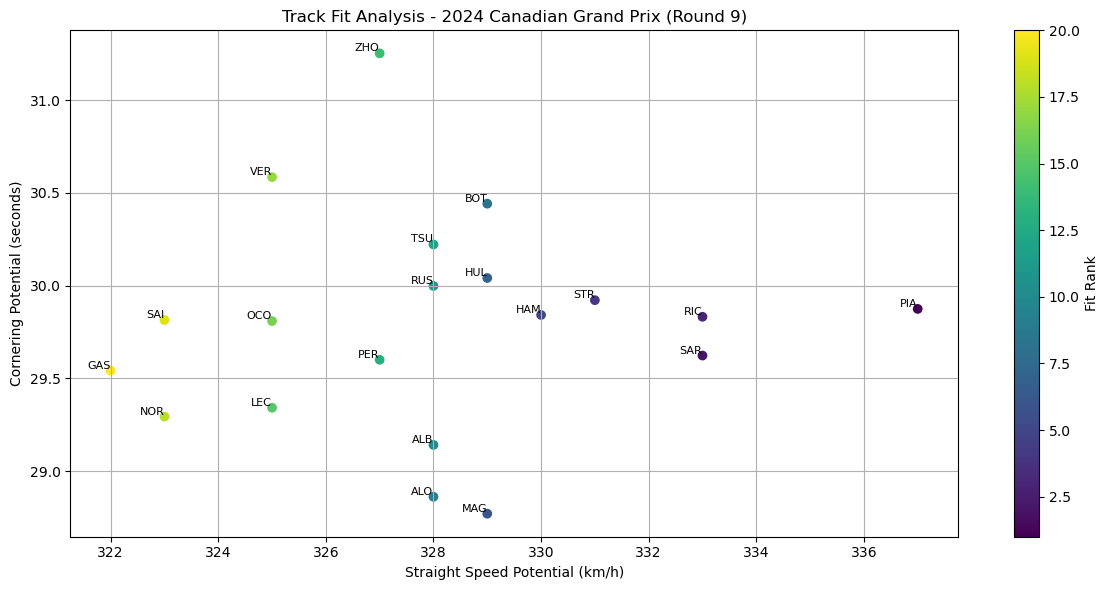

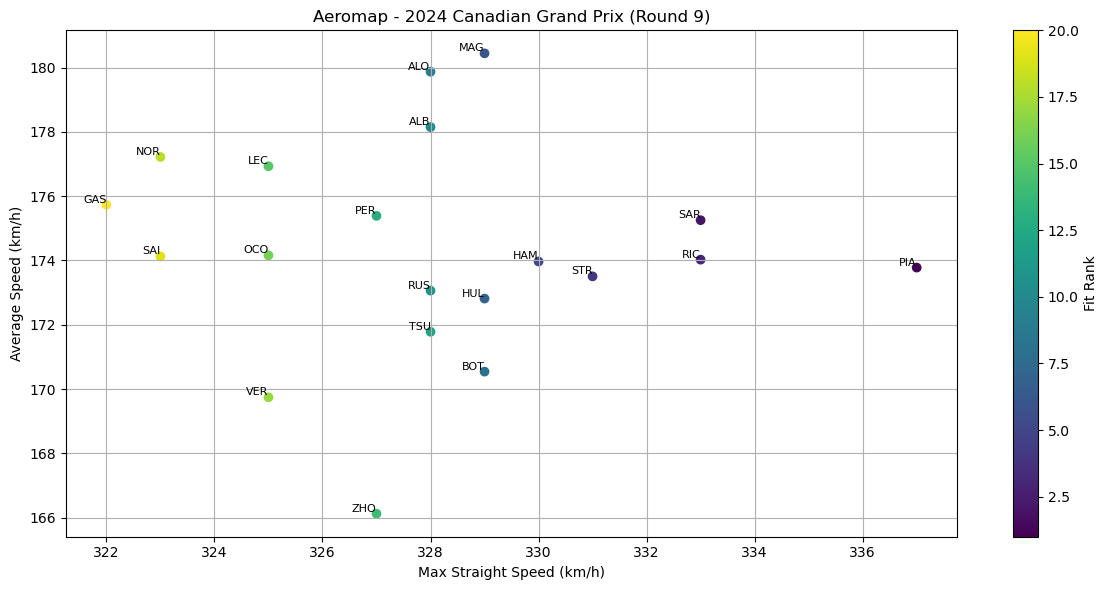

Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_characteristics.csv
Saved driver fit data to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_characteristics_drivers.csv


In [65]:
# Step 9 - Analyze Track Characteristics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fastf1
import os
from scipy.stats import zscore

def analyze_track_characteristics(target_info, cleaned_data):
    """
    Analyze track characteristics and driver compatibility.

    Args:
        target_info (dict): Target event info from Step 2
        cleaned_data (dict): Cleaned data per session from Step 4

    Returns:
        pd.DataFrame: Track characteristics and driver compatibility metrics
    """
    year = target_info['year']
    round_number = target_info['round']
    event_name = target_info.get('event_name', 'Unknown Event')
    data_dir = os.path.join(os.getcwd(), "raw_data", str(year), f"R{round_number}")

    all_laps = pd.concat([cleaned_data[session] for session in cleaned_data.keys()], ignore_index=True)
    required_columns = ['Driver', 'Team', 'SpeedST', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime']
    if not all(col in all_laps.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in all_laps.columns]
        print(f"Warning: Missing columns in cleaned_data: {missing_cols}. Using available data.")
        all_laps = all_laps.dropna(subset=[col for col in required_columns if col in all_laps.columns])

    # Convert time columns to seconds before aggregation
    for col in ['Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime']:
        if col in all_laps.columns:
            if pd.api.types.is_string_dtype(all_laps[col]):
                all_laps[col] = pd.to_timedelta(all_laps[col], errors='coerce')
            if pd.api.types.is_timedelta64_dtype(all_laps[col]):
                all_laps[col] = all_laps[col].dt.total_seconds()
            else:
                # Ensure numeric, convert if necessary
                all_laps[col] = pd.to_numeric(all_laps[col], errors='coerce')

    track_analysis = all_laps.groupby(['Driver', 'Team']).agg({
        'SpeedST': 'max',
        'Sector1Time': 'mean',
        'Sector2Time': 'mean',
        'Sector3Time': 'mean',
        'LapTime': 'mean'
    }).reset_index()

    # Ensure columns are numeric after aggregation
    for col in ['Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime']:
        if col in track_analysis.columns:
            track_analysis[col] = pd.to_numeric(track_analysis[col], errors='coerce')

    try:
        session = fastf1.get_session(year, round_number, 'Practice 3')
        session.load(laps=True, telemetry=True, weather=False)
        circuit_info = session.get_circuit_info()
        lap_length = circuit_info.length / 1000 if hasattr(circuit_info, 'length') else target_info.get('track_length', None)
        drs_zones = len(circuit_info.drs_zones) if hasattr(circuit_info, 'drs_zones') and circuit_info.drs_zones else 3
    except Exception as e:
        print(f"Error fetching circuit info: {e}")
        lap_length = target_info.get('track_length', None)
        drs_zones = 3

    # Ensure lap_length is not None for calculations
    if lap_length is None:
        print("Warning: lap_length is unavailable; skipping AvgSpeed calculation.")
        lap_length = 5.0  # For informational purposes only

    avg_sector_speed = all_laps['SpeedST'].mean()
    max_sector_speed = all_laps['SpeedST'].max()
    downforce_requirement = 'Low' if avg_sector_speed > 330 else 'Medium-High' if avg_sector_speed > 310 else 'High'
    overtaking_difficulty = 'Easy' if drs_zones > 2 else 'Moderate' if drs_zones == 2 else 'Hard'
    try:
        driver_performance = pd.read_csv(os.path.join(data_dir, f"{year}_R{round_number}_driver_performance.csv"))
        avg_tyre_degradation = driver_performance['DegradationSlope'].mean()
        tyre_degradation = 'High' if avg_tyre_degradation > 10 else 'Moderate' if avg_tyre_degradation > 7 else 'Low'
    except Exception as e:
        print(f"Error loading driver performance data: {e}")
        tyre_degradation = 'Moderate'
    suits_fast_cars = 'Yes' if max_sector_speed > 330 else 'No'

    track_characteristics = {
        'Track': event_name,
        'DownforceRequirement': downforce_requirement,
        'OvertakingDifficulty': overtaking_difficulty,
        'DRSZones': drs_zones,
        'TyreDegradation': tyre_degradation,
        'LapLength': lap_length,
        'SuitsFastCars': suits_fast_cars
    }

    track_analysis['StraightSpeedPotential'] = track_analysis['SpeedST']
    track_analysis['CorneringPotential'] = (track_analysis['Sector1Time'] + track_analysis['Sector2Time'] + track_analysis['Sector3Time']) / 3
    if lap_length is not None:
        track_analysis['AvgSpeed'] = (lap_length * 3600) / track_analysis['LapTime']
    else:
        track_analysis['AvgSpeed'] = np.nan  # Skip AvgSpeed if lap_length is unavailable
    straight_line_ratio = track_analysis['StraightSpeedPotential'].mean() / track_analysis['CorneringPotential'].mean()
    weight_straight = straight_line_ratio / (straight_line_ratio + 1) if suits_fast_cars == 'Yes' else 0.4
    weight_cornering = 1 - weight_straight
    track_analysis['StraightZScore'] = zscore(track_analysis['StraightSpeedPotential'])
    track_analysis['CorneringZScore'] = -zscore(track_analysis['CorneringPotential'])
    track_analysis['OverallFit'] = (weight_straight * track_analysis['StraightZScore'] + weight_cornering * track_analysis['CorneringZScore'])

    track_analysis = track_analysis.sort_values('OverallFit', ascending=False)
    track_analysis['FitRank'] = track_analysis['OverallFit'].rank(ascending=False)

    print(f"\nTrack Characteristics Analysis for {event_name}:")
    track_char_df = pd.DataFrame(track_characteristics, index=[0])
    display(track_char_df)
    print(f"\nDriver Fit to Track Characteristics (Top 10) - {event_name}:")
    display(track_analysis[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']].head(10))

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(track_analysis['StraightSpeedPotential'], track_analysis['CorneringPotential'],
                          c=track_analysis['FitRank'], cmap='viridis')
    plt.colorbar(scatter, label='Fit Rank')
    for i, row in track_analysis.iterrows():
        plt.text(row['StraightSpeedPotential'], row['CorneringPotential'], row['Driver'], fontsize=8, ha='right', va='bottom')
    plt.xlabel('Straight Speed Potential (km/h)')
    plt.ylabel('Cornering Potential (seconds)')
    plt.title(f'Track Fit Analysis - {year} {event_name} (Round {round_number})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    if lap_length is not None:
        scatter = plt.scatter(track_analysis['StraightSpeedPotential'], track_analysis['AvgSpeed'],
                              c=track_analysis['FitRank'], cmap='viridis')
        plt.colorbar(scatter, label='Fit Rank')
        for i, row in track_analysis.iterrows():
            plt.text(row['StraightSpeedPotential'], row['AvgSpeed'], row['Driver'], fontsize=8, ha='right', va='bottom')
        plt.xlabel('Max Straight Speed (km/h)')
        plt.ylabel('Average Speed (km/h)')
        plt.title(f'Aeromap - {year} {event_name} (Round {round_number})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping Aeromap plot due to unavailable lap_length.")

    output_file = os.path.join(data_dir, f"{year}_R{round_number}_track_characteristics.csv")
    driver_file = os.path.join(data_dir, f"{year}_R{round_number}_track_characteristics_drivers.csv")
    track_char_df.to_csv(output_file, index=False)
    track_analysis.to_csv(driver_file, index=False)
    print(f"Saved track characteristics to {output_file}")
    print(f"Saved driver fit data to {driver_file}")
    return track_analysis  # Return driver fit data as primary output

# Standalone execution for debugging (runs only if cell is executed directly)
if 'target_info' in globals() and 'cleaned_data' in globals():
    track_char_drivers_df = analyze_track_characteristics(target_info, cleaned_data)
else:
    print("Warning: target_info and/or cleaned_data not found. Run Cells 2 and 4 first for standalone execution.")

# Why: Analyzes track characteristics and driver compatibility based on practice data.
# How to Read: Outputs track characteristics, driver suitability scores, and plots.
# Expected Inputs: target_info from Step 2, cleaned_data from Step 4
# Expected Outputs: Track characteristics DataFrame, driver compatibility DataFrame, saved CSV files, and plots

In [66]:
# Step 10: Race Strategy and Final Prediction
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import fastf1

def predict_race_outcomes(config, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, pit_stop_loss_default=25, overtaking_penalty=0.5):
    year = config.get('year')
    round_number = config.get('round')
    data_dir = config.get('data_dir', "raw_data")
    race_laps = config.get('race_laps', 50)
    event_name = config.get('event_name', "Unknown Event")

    BASE_DIR = os.getcwd()
    round_data_dir = os.path.join(BASE_DIR, data_dir, str(year), f"R{round_number}")
    os.makedirs(round_data_dir, exist_ok=True)

    # Load dynamic pit_stop_loss
    pit_stop_file = os.path.join(BASE_DIR, "pit_stop_loss_by_track.csv")
    if os.path.exists(pit_stop_file):
        pit_stop_df = pd.read_csv(pit_stop_file)
        if event_name in pit_stop_df['Track'].values:
            pit_stop_loss = pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'].values[0]
            print(f"Loaded pit_stop_loss from file: {pit_stop_loss:.2f}s for {event_name}")
        else:
            pit_stop_loss = pit_stop_loss_default
            print(f"No pit_stop_loss found for {event_name} in file, using default: {pit_stop_loss}s")
    else:
        pit_stop_loss = pit_stop_loss_default
        print(f"Pit stop loss file not found, using default: {pit_stop_loss}s")

    # Handle NaN in driver_performance_df
    driver_performance_df['BasePace'] = driver_performance_df['BasePace'].fillna(driver_performance_df['FastestLapTime'] + 5)
    driver_performance_df['DegradationSlope'] = driver_performance_df['DegradationSlope'].fillna(7.0)
    driver_performance_df['LapTimeVar'] = driver_performance_df['LapTimeVar'].fillna(driver_performance_df['BasePace'] * 0.01)

    # Qualifying Prediction
    quali_prediction = driver_performance_df[['Driver', 'FastestLapTime', 'Team']].copy()
    quali_prediction = quali_prediction.rename(columns={'FastestLapTime': 'LapTime'})
    quali_prediction['ExpectedLapTime'] = driver_performance_df['Sector1Time'] + driver_performance_df['Sector2Time'] + driver_performance_df['Sector3Time']
    quali_prediction = quali_prediction.merge(sandbag_analysis_df[['Driver', 'LapTimeDiscrepancy', 'SandbagFlag']], on='Driver', how='left')
    quali_prediction = quali_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit']], on='Driver', how='left')
    quali_prediction['AdjustedLapTime'] = quali_prediction.apply(
        lambda row: row['ExpectedLapTime'] if (row.get('SandbagFlag', False) or (row.get('OverallFit', 0) > 0.5 and row['LapTime'] > row['ExpectedLapTime'])) else row['LapTime'], axis=1
    )
    quali_prediction['QualiPosition'] = quali_prediction['AdjustedLapTime'].rank(method='min').astype(int)

    print("\nQualifying Prediction:")
    display(quali_prediction[['Driver', 'Team', 'LapTime', 'ExpectedLapTime', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition'))

    # Race Strategy Simulation
    strategy_df = driver_performance_df.copy()
    strategy_df['QualiPace'] = quali_prediction['AdjustedLapTime']
    strategy_df['GridPosition'] = quali_prediction['QualiPosition']

    strategy_df['FuelPenalty'] = strategy_df['DegradationSlope'] * (race_laps / 2) / 100 * 2
    strategy_df['TrafficPenalty'] = (strategy_df['LapTimeVar'] / strategy_df['BasePace']) * overtaking_penalty * (race_laps / 50) * 5

    strategies = []
    for _, row in strategy_df.iterrows():
        driver = row['Driver']
        team = row['Team']
        base_pace = row['BasePace']
        deg_rate = row['DegradationSlope'] / 100
        fuel_penalty = row['FuelPenalty']
        traffic_penalty = row['TrafficPenalty'] if row['GridPosition'] > 5 else row['TrafficPenalty'] * 0.5
        grid_pos = row['GridPosition']
        quali_pace = row['QualiPace']

        start_compound = 'MEDIUM' if grid_pos <= 10 else 'SOFT'
        pos_penalty = (grid_pos - 1) * (quali_pace - strategy_df['QualiPace'].min()) / 5
        adjusted_pace = base_pace + pos_penalty + fuel_penalty + traffic_penalty

        max_stint = 27
        if start_compound == 'SOFT':
            first_stint = min(max_stint, max(5, 15 / (max(deg_rate * 3, 0.07))))
        else:
            first_stint = min(max_stint, max(7, 20 / (max(deg_rate * 2, 0.07))))
        second_compound = 'HARD'
        second_stint = race_laps - first_stint

        if first_stint > 7:
            first_stint = 7
            second_stint = race_laps - first_stint

        one_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                         (adjusted_pace + deg_rate * (second_stint / 2)) * second_stint + pit_stop_loss)
        one_stop_stints = [first_stint, second_stint]
        one_stop_compounds = [start_compound, second_compound]

        if deg_rate * race_laps > 1.0:
            first_stint = min(max_stint, race_laps / 3)
            second_compound = 'MEDIUM' if start_compound != 'MEDIUM' else 'SOFT'
            second_stint_length = min(max_stint, (race_laps - first_stint) / 2)
            third_compound = 'HARD'
            third_stint = race_laps - first_stint - second_stint_length
            if third_stint > 0:
                two_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                                 (adjusted_pace + deg_rate * (second_stint_length / 2)) * second_stint_length +
                                 (adjusted_pace + deg_rate * (third_stint / 2)) * third_stint + 2 * pit_stop_loss)
                two_stop_stints = [first_stint, second_stint_length, third_stint]
                two_stop_compounds = [start_compound, second_compound, third_compound]
            else:
                two_stop_pace = one_stop_pace + pit_stop_loss
                two_stop_stints = one_stop_stints
                two_stop_compounds = one_stop_compounds
        else:
            two_stop_pace = float('inf')
            two_stop_stints = []
            two_stop_compounds = []

        best_time = min(one_stop_pace, two_stop_pace)
        strategy = 'One-Stop' if one_stop_pace <= two_stop_pace else 'Two-Stop'
        stint_lengths = one_stop_stints if strategy == 'One-Stop' else two_stop_stints
        compounds = one_stop_compounds if strategy == 'One-Stop' else two_stop_compounds

        strategies.append({
            'Driver': driver,
            'Team': team,
            'GridPosition': grid_pos,
            'QualiPace': quali_pace,
            'BasePace': base_pace,
            'LapTimeVar': row['LapTimeVar'],
            'DegradationSlope': row['DegradationSlope'],
            'FuelPenalty': fuel_penalty,
            'TrafficPenalty': traffic_penalty,
            'CompoundStrategy': '-'.join(compounds),
            'StintLengths': stint_lengths,
            'TotalRaceTime': best_time
        })

    race_prediction = pd.DataFrame(strategies)

    race_prediction = race_prediction.merge(telemetry_metrics_df[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left')
    race_prediction = race_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit', 'AvgSpeed']], on='Driver', how='left')

    p2_lap_time = track_evolution_df[track_evolution_df['Session'] == 'Practice 2']['AvgLapTime'].iloc[0]
    p3_lap_time = track_evolution_df[track_evolution_df['Session'] == 'Practice 3']['AvgLapTime'].iloc[0]
    track_evolution_factor = (p3_lap_time - p2_lap_time) / p2_lap_time

    chaos_factor = (race_prediction['LapTimeVar'].mean() / race_prediction['BasePace'].mean()) * race_prediction['LapTimeVar'].max() / 20
    quali_gaps = race_prediction['QualiPace'].max() - race_prediction['QualiPace'].min()
    overtaking_adjustment = (quali_gaps / (race_prediction['GridPosition'].max() - 1)) * 0.2 if race_prediction['GridPosition'].max() > 1 else 0.2
    race_load_factor = (race_prediction['BasePace'].mean() - race_prediction['QualiPace'].mean()) / (race_laps / 10) * 1.5

    race_prediction['RaceLoad'] = race_load_factor * (race_prediction['LapTimeVar'] / race_prediction['BasePace']) * (race_laps / 2)
    race_prediction['TrackEvolutionAdjustment'] = track_evolution_factor * race_prediction['TotalRaceTime'] * (race_prediction['DegradationSlope'] / 100)
    race_prediction['ConsistencyAdjustment'] = race_prediction['LapTimeVar'] / race_prediction['BasePace'] * 10
    race_prediction['AdjustedRaceTime'] = race_prediction['TotalRaceTime'] + race_prediction['RaceLoad'] + race_prediction['TrackEvolutionAdjustment'] + race_prediction['ConsistencyAdjustment']
    race_prediction['SpeedAdjustment'] = (race_prediction['MaxSpeed'] / race_prediction['MaxSpeed'].max()) * 3
    race_prediction['FitAdjustment'] = (1 - race_prediction['OverallFit'].rank() / len(race_prediction)) * 10
    race_prediction['AvgSpeedAdjustment'] = (race_prediction['AvgSpeed'] / race_prediction['AvgSpeed'].max()) * 20
    race_prediction['AdjustedRaceTime'] = race_prediction['AdjustedRaceTime'] - race_prediction['SpeedAdjustment'] - race_prediction['FitAdjustment'] - race_prediction['AvgSpeedAdjustment']

    for idx, row in race_prediction.iterrows():
        grid_pos = row['GridPosition']
        if grid_pos > 10:
            race_prediction.at[idx, 'AdjustedRaceTime'] += chaos_factor * (grid_pos - 10) / 10
        pos_diff = max(0, grid_pos - 5)
        race_prediction.at[idx, 'AdjustedRaceTime'] += pos_diff * overtaking_adjustment

    race_prediction['FinalPosition'] = race_prediction['AdjustedRaceTime'].rank(method='min').astype(int)

    print("\nFinal Race Prediction:")
    display(race_prediction[['Driver', 'Team', 'GridPosition', 'TotalRaceTime', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition'))

    # Fastest Lap Prediction
    fastest_laps = []
    for session_label in ['Practice 1', 'Practice 2', 'Practice 3']:
        try:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(laps=True)
            laps = session.laps
            for driver in laps['Driver'].unique():
                driver_laps = laps[laps['Driver'] == driver]
                fastest_lap = driver_laps.loc[driver_laps['LapTime'].idxmin()]
                if not pd.isna(fastest_lap['LapTime']):
                    fastest_laps.append({
                        'Driver': driver,
                        'FastestLapTime': fastest_lap['LapTime'].total_seconds(),
                        'Session': session_label
                    })
        except Exception as e:
            print(f"Error loading {session_label} for fastest lap prediction: {e}")
            continue

    if fastest_laps:
        fastest_lap_df = pd.DataFrame(fastest_laps)
        fastest_lap_pred = fastest_lap_df.loc[fastest_lap_df['FastestLapTime'].idxmin(), 'Driver']
        print(f"\nPredicted Fastest Lap Driver: {fastest_lap_pred}")
    else:
        fastest_lap_pred = race_prediction.loc[race_prediction['AdjustedRaceTime'].idxmin(), 'Driver']
        print(f"\nNo fastest lap data available; fallback to race time prediction: {fastest_lap_pred}")

    # Save results
    quali_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_quali_prediction.csv")
    race_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_race_prediction.csv")
    quali_prediction.to_csv(quali_output_file, index=False)
    race_prediction.to_csv(race_output_file, index=False)
    print(f"Saved qualifying prediction to {quali_output_file}")
    print(f"Saved race prediction to {race_output_file}")

    return quali_prediction, race_prediction, fastest_lap_pred

# Debugging: Check variable existence before standalone execution
print("Checking required variables:")
for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df']:
    print(f"{var} exists: {var in globals()}")

# Standalone execution for debugging
if all(var in globals() for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df']):
    quali_prediction_df, race_prediction_df, fastest_lap_pred = predict_race_outcomes(
        target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df
    )
else:
    print("Warning: Required variables (target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df) not found. Run Cells 2, 5, 6, 7, 8, and 9 first for standalone execution.")

Checking required variables:
target_info exists: True
driver_performance_df exists: True
telemetry_metrics_df exists: True
sandbag_analysis_df exists: True
track_evolution_df exists: True
track_char_drivers_df exists: True
Loaded pit_stop_loss from file: 23.06s for Canadian Grand Prix

Qualifying Prediction:


,Driver,Team,LapTime,ExpectedLapTime,AdjustedLapTime,QualiPosition
0,HAM,Mercedes,72.549,72.549,72.549,1
1,VER,Red Bull Racing,72.923,72.923,72.923,2
2,RUS,Mercedes,72.957,72.950,72.950,3
3,STR,Aston Martin,73.026,72.991,72.991,4
4,PIA,McLaren,73.266,73.234,73.234,5
5,RIC,RB,73.279,73.242,73.242,6
6,NOR,McLaren,73.293,73.260,73.293,7
8,ALO,Aston Martin,73.340,73.340,73.340,8
7,PER,Red Bull Racing,73.342,73.308,73.342,9
9,LEC,Ferrari,73.349,73.349,73.349,10



Final Race Prediction:


,Driver,Team,GridPosition,TotalRaceTime,AdjustedRaceTime,FinalPosition
10,MAG,Haas F1 Team,9,4202.538375,4190.658320,1
0,HAM,Mercedes,5,4251.251928,4235.163116,2
8,ALO,Aston Martin,2,4362.469950,4353.189203,3
15,GAS,Alpine,4,4411.461336,4397.224245,4
18,OCO,Alpine,10,4476.037504,4466.744172,5
14,ALB,Williams,1,4481.918010,4475.927382,6
6,NOR,McLaren,8,4515.724510,4501.939957,7
9,LEC,Ferrari,7,4568.731886,4560.758812,8
2,RUS,Mercedes,13,4573.940936,4563.664596,9
11,SAR,Williams,16,4580.269715,4578.617934,10



Predicted Fastest Lap Driver: HAM
Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_quali_prediction.csv
Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_race_prediction.csv


In [67]:
# Step 10.5: Comprehensive Pre-Qualifying Report
import pandas as pd
import os
import matplotlib.pyplot as plt
from fpdf import FPDF
import tempfile
import shutil

def generate_comprehensive_report(config, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred):
    year = config.get('year')
    round_number = config.get('round')
    event_name = config.get('event_name', "Unknown Event")
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")
    BASE_DIR = os.getcwd()
    cleaned_data_dir = os.path.join(BASE_DIR, data_dir, "cleaned_data")
    report_dir = os.path.join(BASE_DIR, "reports", str(year), f"R{round_number}")
    os.makedirs(report_dir, exist_ok=True)

    # Initialize PDF
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", "B", 16)
    pdf.cell(0, 10, f"Pre-Qualifying Report: {year} Round {round_number} - {event_name}", ln=True, align="C")
    pdf.ln(10)

    # Helper function to add DataFrame to PDF
    def add_df_to_pdf(df, title):
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, title, ln=True)
        pdf.set_font("Arial", size=10)
        col_widths = [max([len(str(x)) for x in df[col].values] + [len(col)]) * 5 for col in df.columns]
        total_width = sum(col_widths)
        if total_width > 190:
            scale_factor = 190 / total_width
            col_widths = [w * scale_factor for w in col_widths]
        for i, row in df.iterrows():
            for j, val in enumerate(row):
                pdf.cell(col_widths[j], 10, str(val)[:20], border=1)
            pdf.ln()
        pdf.ln(5)

    # Helper function to add plot to PDF
    def add_plot_to_pdf(fig, title):
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, title, ln=True)
        temp_dir = tempfile.mkdtemp()
        temp_file = os.path.join(temp_dir, f"{title.replace(' ', '_')}.png")
        try:
            fig.savefig(temp_file, format='png', bbox_inches='tight')
            pdf.image(temp_file, x=10, w=190)
        finally:
            plt.close(fig)
            shutil.rmtree(temp_dir, ignore_errors=True)
        pdf.ln(5)

    # Step 1: Event Info
    print("--- Step 1: Event Information ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 1: Event Information", ln=True)
    info_text = (
        f"Year: {year}, Round: {round_number}, Event: {event_name}\n"
        f"Track Length: {config.get('track_length', 'N/A')} km\n"
        f"Average Speed: {config.get('avg_speed', 'N/A')} km/h\n"
        f"Downforce Level: {config.get('downforce_level', 'N/A')}"
    )
    print(info_text)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, info_text)
    pdf.ln(5)

    # Step 2: Historical Data
    print("--- Step 2: Historical Data ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 2: Historical Data", ln=True)
    hist_text = (
        f"Historical Winners: {config.get('historical_winners', 'N/A')}\n"
        f"Historical Poles: {config.get('historical_poles', 'N/A')}"
    )
    print(hist_text)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, hist_text)
    pdf.ln(5)

    # Step 3: Session Data
    print("--- Step 3: Session Data ---")
    session_counts = {}
    for session in ['Practice 1', 'Practice 2', 'Practice 3']:
        try:
            session_file = os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_{session.replace(' ', '_')}_laps.csv")
            session_data = pd.read_csv(session_file)
            session_counts[session] = len(session_data)
            print(f"{session} Lap Count: {session_counts[session]}")
        except Exception as e:
            print(f"Error loading {session} data: {e}")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 3: Session Data", ln=True)
    pdf.set_font("Arial", size=10)
    for session, count in session_counts.items():
        pdf.cell(0, 10, f"{session} Lap Count: {count}", ln=True)
    pdf.ln(5)
    print()

    # Step 4: Data Cleaning Summary
    print("--- Step 4: Data Cleaning Summary ---")
    cleaned_counts = {}
    cleaned_data_files = [f"{year}_R{round_number}_Practice_{i}_cleaned_laps.csv" for i in range(1, 4)]
    for file in cleaned_data_files:
        try:
            cleaned_data = pd.read_csv(os.path.join(cleaned_data_dir, file))
            cleaned_counts[file] = len(cleaned_data)
            print(f"Cleaned {file}: {cleaned_counts[file]} laps")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 4: Data Cleaning Summary", ln=True)
    pdf.set_font("Arial", size=10)
    for file, count in cleaned_counts.items():
        pdf.cell(0, 10, f"Cleaned {file}: {count} laps", ln=True)
    pdf.ln(5)
    print()

    # Step 5: Driver Performance
    print("--- Step 5: Driver Performance ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 5: Driver Performance", ln=True)
    df = driver_performance_df[['Driver', 'FastestLapTime', 'TheoreticalLapTime', 'BasePace', 'DegradationSlope', 'Team']]
    print("Top 5 by Fastest Lap Time:")
    display(df.sort_values('FastestLapTime').head(5))
    add_df_to_pdf(df.sort_values('FastestLapTime').head(5), "Top 5 by Fastest Lap Time")
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = range(5)
    ax.bar([i - bar_width/2 for i in index], df['FastestLapTime'].head(5), bar_width, label='Fastest Lap Time', color='blue')
    ax.bar([i + bar_width/2 for i in index], df['TheoreticalLapTime'].head(5), bar_width, label='Theoretical Lap Time', color='orange')
    ax.set_xlabel('Driver')
    ax.set_ylabel('Lap Time (seconds)')
    ax.set_title(f'Fastest vs. Theoretical Lap Times ({year} Round {round_number})')
    ax.set_xticks(index)
    ax.set_xticklabels(df['Driver'].head(5), rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    add_plot_to_pdf(fig, "Fastest vs. Theoretical Lap Times")
    print()

    # Step 6: Telemetry Metrics
    print("--- Step 6: Telemetry Metrics ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 6: Telemetry Metrics", ln=True)
    df = telemetry_metrics_df[['Driver', 'MaxSpeed', 'ThrottleTime', 'BrakingIntensity', 'Team']]
    print("Top 5 by Max Speed:")
    display(df.sort_values('MaxSpeed', ascending=False).head(5))
    add_df_to_pdf(df.sort_values('MaxSpeed', ascending=False).head(5), "Top 5 by Max Speed")
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    metrics = ['MaxSpeed', 'ThrottleTime', 'BrakingIntensity']
    titles = ['Max Speed (km/h)', '% Time at Full Throttle', 'Avg Braking Intensity (0-1)']
    colors = ['blue', 'orange', 'green']
    for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        plot_data = df[df[metric] > 0] if metric == 'ThrottleTime' else df
        sorted_data = plot_data.sort_values(metric, ascending=False).head(5)
        axs[i].bar(sorted_data['Driver'], sorted_data[metric], color=color)
        axs[i].set_title(f'Telemetry Metrics - {title}')
        axs[i].set_xlabel('Driver')
        axs[i].set_ylabel(title)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True)
    plt.tight_layout()
    add_plot_to_pdf(fig, "Telemetry Metrics")
    print()

    # Step 7: Sandbagging Analysis
    print("--- Step 7: Sandbagging Analysis ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 7: Sandbagging Analysis", ln=True)
    df = sandbag_analysis_df[['Driver', 'Team', 'FastestLapTime', 'MaxSpeed', 'PredictionDiscrepancy', 'SandbagFlag']]
    print("Potential Sandbaggers:")
    display(df[df['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False))
    add_df_to_pdf(df[df['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False), "Potential Sandbaggers")
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue' if not flag else 'red' for flag in df['SandbagFlag']]
    ax.scatter(df['FastestLapTime'], df['MaxSpeed'], c=colors, alpha=0.6)
    ax.axhline(y=df['MaxSpeed'].mean(), color='gray', linestyle='--', label='Mean Max Speed')
    ax.set_xlabel('Fastest Lap Time (seconds)')
    ax.set_ylabel('Max Speed (km/h)')
    ax.set_title(f'Sandbagging Analysis ({year} Round {round_number})')
    for i, row in df.iterrows():
        ax.text(row['FastestLapTime'], row['MaxSpeed'], row['Driver'], fontsize=8, ha='right')
    ax.legend()
    ax.grid(True)
    add_plot_to_pdf(fig, "Sandbagging Analysis: Fastest Lap Time vs. Max Speed")
    print()

    # Step 8: Track Evolution and Weather
    print("--- Step 8: Track Evolution and Weather ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 8: Track Evolution and Weather", ln=True)
    df = track_evolution_df[['Session', 'AvgLapTime', 'StdLapTime', 'LapCount']]
    print("Average Lap Times Across Sessions:")
    display(df)
    add_df_to_pdf(df, "Average Lap Times Across Sessions")
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df['Session'], df['AvgLapTime'], marker='o', color='blue', label='Avg Lap Time (s)')
    ax1.fill_between(df['Session'], df['AvgLapTime'] - df['StdLapTime'] / 2, df['AvgLapTime'] + df['StdLapTime'] / 2, color='blue', alpha=0.2, label='Std Dev (±0.5σ)')
    ax1.set_xlabel('Session')
    ax1.set_ylabel('Average Lap Time (seconds)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(df['Session'])
    ax1.set_xticklabels(['P1', 'P2', 'P3'], rotation=45)
    ax1.grid(True)
    ax1.legend(loc='upper left')
    add_plot_to_pdf(fig, "Track Evolution: Average Lap Times")
    print()

    # Step 9: Track Characteristics
    print("--- Step 9: Track Characteristics ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 9: Track Characteristics", ln=True)
    track_char_df = pd.read_csv(os.path.join(BASE_DIR, data_dir, f"{year}_R{round_number}_track_characteristics.csv"))
    print("Track Characteristics:")
    display(track_char_df)
    add_df_to_pdf(track_char_df, "Track Characteristics")
    df = track_char_drivers_df[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']]
    print("Top 5 Drivers by Track Fit:")
    display(df.sort_values('FitRank').head(5))
    add_df_to_pdf(df.sort_values('FitRank').head(5), "Top 5 Drivers by Track Fit")
    fig, ax = plt.subplots(figsize=(12, 6))
    scatter = ax.scatter(df['StraightSpeedPotential'], df['AvgSpeed'], c=df['FitRank'], cmap='viridis')
    plt.colorbar(scatter, label='Fit Rank')
    for i, row in df.iterrows():
        ax.text(row['StraightSpeedPotential'], row['AvgSpeed'], row['Driver'], fontsize=8, ha='right')
    ax.set_xlabel('Max Straight Speed (km/h)')
    ax.set_ylabel('Average Speed (km/h)')
    ax.set_title(f'Aeromap ({year} Round {round_number})')
    ax.grid(True)
    add_plot_to_pdf(fig, "Aeromap: Max Speed vs. Average Speed")
    print()

    # Step 10: Predictions
    print("--- Step 10: Predictions ---")
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 10: Predictions", ln=True)
    quali_df = quali_prediction_df[['Driver', 'Team', 'AdjustedLapTime', 'QualiPosition']]
    print("Predicted Qualifying Top 5:")
    display(quali_df.sort_values('QualiPosition').head(5))
    add_df_to_pdf(quali_df.sort_values('QualiPosition').head(5), "Predicted Qualifying Top 5")
    race_df = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']]
    print("Predicted Race Top 10:")
    display(race_df.sort_values('FinalPosition').head(10))
    add_df_to_pdf(race_df.sort_values('FinalPosition').head(10), "Predicted Race Top 10")
    pdf.set_font("Arial", size=10)
    pdf.cell(0, 10, f"Predicted Fastest Lap Driver: {fastest_lap_pred}", ln=True)
    print(f"Predicted Fastest Lap Driver: {fastest_lap_pred}\n")

    # Save PDF
    pdf_output = os.path.join(report_dir, f"{year}_R{round_number}_pre_qualifying_report.pdf")
    pdf.output(pdf_output)
    print(f"Report saved to {pdf_output}")

# Standalone execution for debugging (runs only if required variables are in scope)
if all(var in globals() for var in ['target_info', 'driver_performance_df', 'telemetry_metrics_df', 'sandbag_analysis_df', 'track_evolution_df', 'track_char_drivers_df', 'quali_prediction_df', 'race_prediction_df', 'fastest_lap_pred']):
    generate_comprehensive_report(
        target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df,
        track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred
    )
else:
    print("Warning: Required variables (target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred) not found. Run Cells 2, 5, 6, 7, 8, 9, and 10 first for standalone execution.")

--- Step 1: Event Information ---
Year: 2024, Round: 9, Event: Canadian Grand Prix
Track Length: 4.32630900597123 km
Average Speed: 184.45801411140437 km/h
Downforce Level: Medium
--- Step 2: Historical Data ---
Historical Winners: [(2019, 'Lewis Hamilton', 1), (2020, 'Pierre Gasly', 1), (2021, 'Max Verstappen', 1), (2022, 'Max Verstappen', 1), (2023, 'Max Verstappen', 1)]
Historical Poles: [(2019, 'Sebastian Vettel', 1), (2020, 'Lewis Hamilton', 1), (2021, 'Charles Leclerc', 1), (2022, 'Max Verstappen', 1), (2023, 'Max Verstappen', 1)]
--- Step 3: Session Data ---
Practice 1 Lap Count: 133
Practice 2 Lap Count: 437
Practice 3 Lap Count: 578

--- Step 4: Data Cleaning Summary ---
Cleaned 2024_R9_Practice_1_cleaned_laps.csv: 58 laps
Cleaned 2024_R9_Practice_2_cleaned_laps.csv: 315 laps
Cleaned 2024_R9_Practice_3_cleaned_laps.csv: 407 laps

--- Step 5: Driver Performance ---
Top 5 by Fastest Lap Time:


,Driver,FastestLapTime,TheoreticalLapTime,BasePace,DegradationSlope,Team
4,HAM,72.549,72.549,83.552069,0.540718,Mercedes
18,VER,72.923,72.923,90.493222,0.224089,Red Bull Racing
13,RUS,72.957,72.950,87.822778,0.569328,Mercedes
16,STR,73.026,72.991,88.545789,0.100000,Aston Martin
11,PIA,73.266,73.234,89.529095,0.100000,McLaren



--- Step 6: Telemetry Metrics ---
Top 5 by Max Speed:


,Driver,MaxSpeed,ThrottleTime,BrakingIntensity,Team
14,RUS,327.333333,49.045946,0.217064,Mercedes
16,SAR,326.666667,46.182828,0.228125,Williams
13,RIC,324.000000,51.075449,0.205217,RB
10,OCO,323.000000,54.895685,0.209815,Alpine
12,PIA,322.333333,0.048733,0.213671,McLaren



--- Step 7: Sandbagging Analysis ---
Potential Sandbaggers:


,Driver,Team,FastestLapTime,MaxSpeed,PredictionDiscrepancy,SandbagFlag
11,SAR,Williams,73.663,326.666667,1.202980,True
18,OCO,Alpine,74.075,323.000000,1.005244,True
2,RUS,Mercedes,72.957,327.333333,0.607841,True
5,RIC,RB,73.279,324.000000,0.375535,True
10,MAG,Haas F1 Team,73.439,322.000000,0.202952,True
16,TSU,RB,73.716,320.333333,0.202799,True



--- Step 8: Track Evolution and Weather ---
Average Lap Times Across Sessions:


,Session,AvgLapTime,StdLapTime,LapCount
0,Practice 1,92.010741,5.480808,58
1,Practice 2,90.747054,14.262214,315
2,Practice 3,87.664076,16.575574,407



--- Step 9: Track Characteristics ---
Track Characteristics:


,Track,DownforceRequirement,OvertakingDifficulty,DRSZones,TyreDegradation,LapLength,SuitsFastCars
0,Canadian Grand Prix,High,Easy,3,Low,4.326309,Yes


Top 5 Drivers by Track Fit:


,Driver,Team,StraightSpeedPotential,CorneringPotential,AvgSpeed,OverallFit,FitRank
11,PIA,McLaren,337.0,29.874650,173.778467,2.267196,1.0
15,SAR,Williams,333.0,29.623315,175.252863,1.291039,2.0
12,RIC,RB,333.0,29.832222,174.025615,1.260299,3.0
16,STR,Aston Martin,331.0,29.921624,173.505650,0.740574,4.0
4,HAM,Mercedes,330.0,29.842064,173.968223,0.498996,5.0



--- Step 10: Predictions ---
Predicted Qualifying Top 5:


,Driver,Team,AdjustedLapTime,QualiPosition
0,HAM,Mercedes,72.549,1
1,VER,Red Bull Racing,72.923,2
2,RUS,Mercedes,72.950,3
3,STR,Aston Martin,72.991,4
4,PIA,McLaren,73.234,5


Predicted Race Top 10:


,Driver,Team,GridPosition,AdjustedRaceTime,FinalPosition
10,MAG,Haas F1 Team,9,4190.658320,1
0,HAM,Mercedes,5,4235.163116,2
8,ALO,Aston Martin,2,4353.189203,3
15,GAS,Alpine,4,4397.224245,4
18,OCO,Alpine,10,4466.744172,5
14,ALB,Williams,1,4475.927382,6
6,NOR,McLaren,8,4501.939957,7
9,LEC,Ferrari,7,4560.758812,8
2,RUS,Mercedes,13,4563.664596,9
11,SAR,Williams,16,4578.617934,10


Predicted Fastest Lap Driver: HAM

Report saved to C:\data\Dropbox\dev\F1\reports\2024\R9\2024_R9_pre_qualifying_report.pdf


In [68]:
# Step 11: Final Summary Report
import pandas as pd
import os
import fastf1
import numpy as np

def generate_summary_report(config, quali_prediction_df, race_prediction_df, fastest_lap_pred):
    year = config.get('year')
    round_number = config.get('round')
    data_dir = os.path.join("raw_data", str(year), f"R{round_number}")
    event_name = config.get('event_name', "Unknown Event")
    BASE_DIR = os.getcwd()

    print("Debug: Verifying input DataFrames...")
    print(f"quali_prediction_df shape: {quali_prediction_df.shape if quali_prediction_df is not None else 'None'}")
    print(f"race_prediction_df shape: {race_prediction_df.shape if race_prediction_df is not None else 'None'}")

    round_data_dir = os.path.join(BASE_DIR, data_dir)
    driver_performance_file = os.path.join(round_data_dir, f"{year}_R{round_number}_driver_performance.csv")
    try:
        driver_performance = pd.read_csv(driver_performance_file)
    except Exception as e:
        print(f"Error loading driver performance data: {e}")
        driver_performance = pd.DataFrame()

    # Load pit_stop_loss
    pit_stop_file = os.path.join(BASE_DIR, "pit_stop_loss_by_track.csv")
    if os.path.exists(pit_stop_file):
        pit_stop_df = pd.read_csv(pit_stop_file)
        if event_name in pit_stop_df['Track'].values:
            pit_stop_loss = pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'].values[0]
            print(f"Loaded pit_stop_loss for comparison: {pit_stop_loss:.2f}s for {event_name}")
        else:
            pit_stop_loss = 20.0
            print(f"No pit_stop_loss found for {event_name} in file, using default: {pit_stop_loss}s")
    else:
        pit_stop_loss = 20.0
        print(f"Pit stop loss file not found, using default: {pit_stop_loss}s")

    # Fetch actual results
    try:
        quali_session = fastf1.get_session(year, round_number, 'Q')
        quali_session.load()
        race_session = fastf1.get_session(year, round_number, 'R')
        race_session.load()
        quali_results = quali_session.results
        race_results = race_session.results
        actual_quali_top_5 = quali_results['Abbreviation'].head(5).tolist()
        actual_race_top_10 = race_results['Abbreviation'].head(10).tolist()
        laps = race_session.laps
        fastest_lap_driver = laps.pick_fastest()['Driver']

        actual_race_pace = laps[laps['PitInTime'].isna() & laps['LapTime'].notna()].groupby('Driver')['LapTime'].mean().dt.total_seconds().reset_index()
        actual_race_pace.columns = ['Driver', 'ActualRacePace']

        actual_deg = laps[laps['TyreLife'].notna() & laps['LapTime'].notna()].groupby('Driver').apply(
            lambda x: np.polyfit(x['TyreLife'], x['LapTime'].dt.total_seconds(), 1)[0] * 100 if len(x) > 5 else np.nan,
            include_groups=False
        ).reset_index()
        actual_deg.columns = ['Driver', 'ActualDegradationSlope']

        actual_overtakes = race_results[['Abbreviation', 'GridPosition', 'Position']].dropna()
        actual_overtakes['Position'] = actual_overtakes['Position'].astype(int)
        actual_overtakes['Overtakes'] = actual_overtakes['GridPosition'] - actual_overtakes['Position']
        actual_overtakes = actual_overtakes[['Abbreviation', 'Overtakes']]
        actual_overtakes.columns = ['Driver', 'ActualOvertakes']

        pit_in_laps = laps[laps['PitInTime'].notna()].copy()
        if not pit_in_laps.empty:
            avg_clean_lap = actual_race_pace.set_index('Driver')['ActualRacePace']
            pit_in_laps['PitDuration'] = pit_in_laps.apply(
                lambda row: row['LapTime'].total_seconds() - avg_clean_lap.get(row['Driver'], row['LapTime'].total_seconds()) if pd.notna(row['LapTime']) else np.nan,
                axis=1
            )
            pit_stops = pit_in_laps.groupby('Driver').agg(
                NumPitStops=pd.NamedAgg(column='PitInTime', aggfunc='count'),
                TotalPitTime=pd.NamedAgg(column='PitDuration', aggfunc='sum'),
                AvgPitTime=pd.NamedAgg(column='PitDuration', aggfunc='mean')
            ).reset_index()
            print("Debug: Sample pit stop durations:")
            print(pit_in_laps[['Driver', 'LapNumber', 'LapTime', 'PitDuration']].head())
        else:
            print("Warning: No pit-in laps found. Pit stop data unavailable.")
            pit_stops = pd.DataFrame(columns=['Driver', 'NumPitStops', 'TotalPitTime', 'AvgPitTime'])

        actual_tyres = laps.groupby('Driver')['Compound'].unique().reset_index()
        actual_tyres['ActualTyreStrategy'] = actual_tyres['Compound'].apply(lambda x: '-'.join(x))

        track_pit_stop_loss = pit_stops['AvgPitTime'].mean() if not pit_stops.empty else 20.0
        print(f"Calculated pit_stop_loss for {event_name}: {track_pit_stop_loss:.2f}s")
        if os.path.exists(pit_stop_file):
            pit_stop_df = pd.read_csv(pit_stop_file)
            if event_name in pit_stop_df['Track'].values:
                pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'] = track_pit_stop_loss
            else:
                pit_stop_df = pd.concat([pit_stop_df, pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})], ignore_index=True)
        else:
            pit_stop_df = pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})
        pit_stop_df.to_csv(pit_stop_file, index=False)
        print(f"Saved pit_stop_loss to {pit_stop_file}")

        print(f"Dynamically fetched actual qualifying top 5: {actual_quali_top_5}")
        print(f"Dynamically fetched actual race top 10: {actual_race_top_10}")
        print(f"Dynamically fetched actual fastest lap driver: {fastest_lap_driver}")
    except Exception as e:
        print(f"Error fetching actual results from FastF1: {e}")
        print("Falling back to placeholder results.")
        actual_quali_top_5 = ['Unknown'] * 5
        actual_race_top_10 = ['Unknown'] * 10
        fastest_lap_driver = 'Unknown'
        actual_race_pace = pd.DataFrame()
        actual_deg = pd.DataFrame()
        actual_overtakes = pd.DataFrame()
        pit_stops = pd.DataFrame()
        actual_tyres = pd.DataFrame()

    print("\n=== Comprehensive Summary Report ===")
    print(f"\nEvent: {year} Round {round_number} - {event_name}")

    print("\n--- Qualifying Analysis ---")
    print("Actual Qualifying Top 5:", actual_quali_top_5)
    print("Predicted Qualifying Top 5:")
    quali_pred_df = quali_prediction_df[['Driver', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition').head(5)
    display(quali_pred_df)

    print("\n--- Race Analysis ---")
    print("Actual Race Top 10:", actual_race_top_10)
    print("Predicted Race Top 10:")
    race_pred_df = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition').head(10)
    display(race_pred_df)

    print("\n--- Detailed Prediction vs. Actual Comparison ---")
    comparison_df = race_prediction_df[['Driver', 'GridPosition', 'FinalPosition', 'BasePace', 'DegradationSlope', 'FuelPenalty', 'TrafficPenalty', 'CompoundStrategy', 'StintLengths']].merge(
        actual_race_pace, on='Driver', how='left'
    ).merge(
        actual_deg, on='Driver', how='left'
    ).merge(
        actual_overtakes, on='Driver', how='left'
    ).merge(
        pit_stops, on='Driver', how='left'
    ).merge(
        actual_tyres[['Driver', 'ActualTyreStrategy']], on='Driver', how='left'
    )
    comparison_df['PaceError'] = comparison_df['BasePace'] - comparison_df['ActualRacePace']
    comparison_df['DegError'] = comparison_df['DegradationSlope'] - comparison_df['ActualDegradationSlope']
    comparison_df['PositionError'] = comparison_df['FinalPosition'] - comparison_df['ActualOvertakes'].fillna(0).apply(lambda x: len(actual_race_top_10) + 1 - x if x > 0 else len(actual_race_top_10) + 1)
    comparison_df['PitStopCountError'] = comparison_df['NumPitStops'].fillna(0) - comparison_df['CompoundStrategy'].apply(lambda x: len(x.split('-')) - 1)
    comparison_df['PitTimeError'] = (comparison_df['NumPitStops'].fillna(0) * pit_stop_loss) - comparison_df['TotalPitTime'].fillna(0)
    display(comparison_df)

    results_file = os.path.join(round_data_dir, f"{year}_R{round_number}_summary_results.csv")
    comparison_df.to_csv(results_file, index=False)
    print(f"\nSaved detailed results to {results_file}")

    print("\n--- Insights for Improvement ---")
    print("1. **Race Pace Errors**:")
    pace_error_mean = comparison_df['PaceError'].mean()
    print(f"Mean Pace Error: {pace_error_mean:.2f} seconds")
    if abs(pace_error_mean) > 2:
        print(f" - Suggestion: Adjust BasePace calculation. Current model {'overestimates' if pace_error_mean > 0 else 'underestimates'} race pace by {abs(pace_error_mean):.2f}s.")

    print("2. **Degradation Errors**:")
    deg_error_mean = comparison_df['DegError'].mean()
    print(f"Mean Degradation Error: {deg_error_mean:.2f}%")
    if abs(deg_error_mean) > 5:
        print(f" - Suggestion: Refine DegradationSlope estimation. Model {'overestimates' if deg_error_mean > 0 else 'underestimates'} tyre wear by {abs(deg_error_mean):.2f}%.")

    print("3. **Overtaking Accuracy**:")
    overtake_error_mean = comparison_df['ActualOvertakes'].fillna(0) - (comparison_df['GridPosition'] - comparison_df['FinalPosition'])
    print(f"Mean Overtaking Error: {overtake_error_mean.mean():.2f} positions")
    if abs(overtake_error_mean.mean()) > 2:
        print(f" - Suggestion: Adjust overtaking_penalty (0.5s) or TrafficPenalty. Predictions {'underestimate' if overtake_error_mean.mean() > 0 else 'overestimate'} overtaking by {abs(overtake_error_mean.mean()):.2f} positions.")

    print("4. **Pit Stop Strategy**:")
    pit_count_error_mean = comparison_df['PitStopCountError'].mean()
    print(f"Mean Pit Stop Count Error: {pit_count_error_mean:.2f} stops")
    if abs(pit_count_error_mean) > 0.5:
        print(f" - Suggestion: Refine stint length logic. Model {'overestimates' if pit_count_error_mean < 0 else 'underestimates'} pit stops by {abs(pit_count_error_mean):.2f}.")

    print("5. **Pit Stop Time**:")
    pit_time_error_mean = comparison_df['PitTimeError'].mean()
    print(f"Mean Pit Time Error: {pit_time_error_mean:.2f} seconds")
    if abs(pit_time_error_mean) > 5:
        print(f" - Suggestion: Adjust pit_stop_loss ({pit_stop_loss:.2f}s). Actual pit times are {'shorter' if pit_time_error_mean > 0 else 'longer'} by {abs(pit_time_error_mean):.2f}s.")

    print("\n--- Driver Performance Metrics ---")
    print("Fastest Lap Times:")
    display(driver_performance[['Driver', 'FastestLapTime', 'Team']].sort_values('FastestLapTime'))

    print("\n--- F1 Fantasy League Scoring ---")
    quali_top_5_pred = quali_prediction_df.sort_values('QualiPosition').head(5)['Driver'].tolist()
    race_top_10_pred = race_prediction_df.sort_values('FinalPosition').head(10)['Driver'].tolist()
    podium_pred = race_top_10_pred[:3]
    podium_actual = actual_race_top_10[:3]

    podium_points = 0
    podium_details = []
    for position, (pred, act) in enumerate(zip(podium_pred, podium_actual), 1):
        points = 0
        if pred in actual_race_top_10:
            points += 1
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
        if pred == act:
            points += 1
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (exact position)")
        if points == 0:
            podium_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
        podium_points += points
    if set(podium_pred).issubset(set(podium_actual)):
        podium_points += 2
        podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 2pt (all 3 correct)")
    else:
        podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 0pt (not all 3 correct)")

    top_10_points = 0
    top_10_details = []
    for position, (pred, act) in enumerate(zip(race_top_10_pred[3:], actual_race_top_10[3:]), 4):
        points = 0
        if pred in actual_race_top_10:
            points += 1
            top_10_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
            if pred == act:
                points += 0.5
                top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0.5pt (exact position)")
        else:
            top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
        top_10_points += points

    fastest_lap_points = 1 if fastest_lap_pred == fastest_lap_driver else 0
    fastest_lap_detail = f"Fastest Lap   {fastest_lap_driver:<15} {fastest_lap_pred:<15} {fastest_lap_points}pt"

    total_points = podium_points + top_10_points + fastest_lap_points

    print("\nRace Results")
    print(f"{'Actual':<15} {'You':<15} {'Points':<15}")
    print("-" * 45)
    pole_pred = quali_prediction_df.sort_values('QualiPosition').head(1)['Driver'].tolist()[0]
    print(f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 2pt" if pole_pred == actual_quali_top_5[0] else f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 0pt")
    print(fastest_lap_detail)
    for detail in podium_details:
        print(detail)
    for detail in top_10_details:
        print(detail)

    print(f"\nTotal Fantasy League Points: {total_points}")
    print(f"Maximum Possible Points: 20")

# Standalone execution for debugging (runs only if required variables are in scope)
if all(var in globals() for var in ['target_info', 'quali_prediction_df', 'race_prediction_df', 'fastest_lap_pred']):
    generate_summary_report(target_info, quali_prediction_df, race_prediction_df, fastest_lap_pred)
else:
    print("Warning: Required variables (target_info, quali_prediction_df, race_prediction_df, fastest_lap_pred) not found. Run Cells 2 and 10 first for standalone execution.")

Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 24)
Loaded pit_stop_loss for comparison: 23.06s for Canadian Grand Prix
Debug: Sample pit stop durations:
    Driver  LapNumber                LapTime  PitDuration
24     VER       25.0 0 days 00:01:53.896000    23.698662
44     VER       45.0 0 days 00:01:40.612000    10.414662
94     GAS       25.0 0 days 00:02:08.873000    38.478765
109    GAS       40.0 0 days 00:01:42.267000    11.872765
164    PER       25.0 0 days 00:02:16.416000    45.143633
Calculated pit_stop_loss for Canadian Grand Prix: 23.06s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['RUS', 'VER', 'NOR', 'PIA', 'RIC']
Dynamically fetched actual race top 10: ['VER', 'NOR', 'RUS', 'HAM', 'PIA', 'ALO', 'STR', 'RIC', 'GAS', 'OCO']
Dynamically fetched actual fastest lap driver: HAM

=== Comprehensive Summary Report ===

Event: 2024 Round 9 - Canadian 

,Driver,AdjustedLapTime,QualiPosition
0,HAM,72.549,1
1,VER,72.923,2
2,RUS,72.950,3
3,STR,72.991,4
4,PIA,73.234,5



--- Race Analysis ---
Actual Race Top 10: ['VER', 'NOR', 'RUS', 'HAM', 'PIA', 'ALO', 'STR', 'RIC', 'GAS', 'OCO']
Predicted Race Top 10:


,Driver,Team,GridPosition,AdjustedRaceTime,FinalPosition
10,MAG,Haas F1 Team,9,4190.658320,1
0,HAM,Mercedes,5,4235.163116,2
8,ALO,Aston Martin,2,4353.189203,3
15,GAS,Alpine,4,4397.224245,4
18,OCO,Alpine,10,4466.744172,5
14,ALB,Williams,1,4475.927382,6
6,NOR,McLaren,8,4501.939957,7
9,LEC,Ferrari,7,4560.758812,8
2,RUS,Mercedes,13,4563.664596,9
11,SAR,Williams,16,4578.617934,10



--- Detailed Prediction vs. Actual Comparison ---


,Driver,GridPosition,FinalPosition,BasePace,DegradationSlope,FuelPenalty,TrafficPenalty,CompoundStrategy,StintLengths,ActualRacePace,...,ActualOvertakes,NumPitStops,TotalPitTime,AvgPitTime,ActualTyreStrategy,PaceError,DegError,PositionError,PitStopCountError,PitTimeError
0,HAM,5,2,83.552069,0.540718,0.270359,0.090770,MEDIUM-HARD,"[7, 43]",89.731060,...,3.0,3.0,71.667821,23.889274,INTERMEDIATE-MEDIUM-HARD,-6.178991,75.545729,-6.0,2.0,-2.486027
1,VER,19,19,90.493222,0.224089,0.112045,0.563458,SOFT-HARD,"[7, 43]",90.197338,...,1.0,2.0,34.113324,17.056662,INTERMEDIATE-MEDIUM,0.295884,75.940192,9.0,1.0,12.007872
2,RUS,13,9,87.822778,0.569328,0.284664,0.351706,SOFT-HARD,"[7, 43]",89.801881,...,-2.0,3.0,66.112358,22.037453,INTERMEDIATE-HARD-MEDIUM,-1.979103,72.797373,-2.0,2.0,3.069435
3,STR,15,13,88.545789,0.100000,0.050000,0.490717,SOFT-HARD,"[7, 43]",90.392324,...,2.0,2.0,44.089353,22.044676,INTERMEDIATE-HARD,-1.846534,63.998329,4.0,1.0,2.031843
4,PIA,12,12,89.529095,0.100000,0.050000,0.457146,SOFT-HARD,"[7, 43]",90.364853,...,-1.0,2.0,32.586294,16.293147,INTERMEDIATE-MEDIUM,-0.835758,77.847246,1.0,1.0,13.534902
5,RIC,14,14,88.987556,0.291676,0.145838,0.420080,SOFT-HARD,"[7, 43]",90.321794,...,-3.0,2.0,54.073412,27.036706,INTERMEDIATE-MEDIUM,-1.334239,44.400509,3.0,1.0,-7.952216
6,NOR,8,7,88.001476,0.548205,0.274103,0.366250,MEDIUM-HARD,"[7, 43]",89.858103,...,1.0,2.0,61.738794,30.869397,INTERMEDIATE-MEDIUM,-1.856627,67.011257,-3.0,1.0,-15.617598
7,PER,11,11,89.046429,0.107852,0.053926,0.474745,SOFT-HARD,"[7, 43]",91.272367,...,-2.0,3.0,55.877265,27.938633,INTERMEDIATE-MEDIUM,-2.225939,18.809061,0.0,2.0,13.304528
8,ALO,2,3,86.463190,0.100000,0.050000,0.181217,MEDIUM-HARD,"[7, 43]",90.383838,...,0.0,2.0,38.568324,19.284162,INTERMEDIATE-HARD,-3.920648,73.970072,-8.0,1.0,7.552872
9,LEC,7,8,89.286095,0.411412,0.205706,0.450739,MEDIUM-HARD,"[7, 43]",93.133622,...,-8.0,4.0,117.963135,39.321045,INTERMEDIATE-HARD,-3.847526,57.408827,-3.0,3.0,-25.720744



Saved detailed results to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_summary_results.csv

--- Insights for Improvement ---
1. **Race Pace Errors**:
Mean Pace Error: -2.18 seconds
 - Suggestion: Adjust BasePace calculation. Current model underestimates race pace by 2.18s.
2. **Degradation Errors**:
Mean Degradation Error: 52.38%
 - Suggestion: Refine DegradationSlope estimation. Model overestimates tyre wear by 52.38%.
3. **Overtaking Accuracy**:
Mean Overtaking Error: -1.95 positions
4. **Pit Stop Strategy**:
Mean Pit Stop Count Error: 1.25 stops
 - Suggestion: Refine stint length logic. Model underestimates pit stops by 1.25.
5. **Pit Stop Time**:
Mean Pit Time Error: -0.19 seconds

--- Driver Performance Metrics ---
Fastest Lap Times:


,Driver,FastestLapTime,Team
0,HAM,72.549,Mercedes
1,VER,72.923,Red Bull Racing
2,RUS,72.957,Mercedes
3,STR,73.026,Aston Martin
4,PIA,73.266,McLaren
5,RIC,73.279,RB
6,NOR,73.293,McLaren
8,ALO,73.340,Aston Martin
7,PER,73.342,Red Bull Racing
9,LEC,73.349,Ferrari



--- F1 Fantasy League Scoring ---

Race Results
Actual          You             Points         
---------------------------------------------
Pole          RUS             HAM             0pt
Fastest Lap   HAM             HAM             1pt
P1           VER             MAG             0pt
P2           NOR             HAM             1pt (in top 10)
P3           RUS             ALO             1pt (in top 10)
Podium Bonus  ['VER', 'NOR', 'RUS'] ['MAG', 'HAM', 'ALO'] 0pt (not all 3 correct)
P4           HAM             GAS             1pt (in top 10)
P5           PIA             OCO             1pt (in top 10)
P6           ALO             ALB             0pt
P7           STR             NOR             1pt (in top 10)
P8           RIC             LEC             0pt
P9           GAS             RUS             1pt (in top 10)
P10           OCO             SAR             0pt

Total Fantasy League Points: 7
Maximum Possible Points: 20


In [70]:
# Step 12: Batch Process Multiple Rounds
# Objective: Process multiple rounds in a single execution, integrating all previous steps.

import os
import pandas as pd
from datetime import datetime

def batch_process_rounds(year, rounds, data_dir="raw_data", force_redownload=False):
    """
    Batch process multiple rounds for a given year, integrating all previous steps.

    Args:
        year (int): The year to process (e.g., 2024)
        rounds (list): List of round numbers to process (e.g., [1, 2, 3])
        data_dir (str): Directory for raw data (default: "raw_data")
        force_redownload (bool): Whether to force re-download of data (default: False)
    """
    for round_number in rounds:
        print(f"\nProcessing {year} Round {round_number}...")
        try:
            # Step 2: Define target event
            target_info = get_target_event(year, round_number)

            # Step 4: Load and clean practice data
            cleaned_data = load_existing_practice_data(year, round_number, target_info['session_types'], data_dir=data_dir, force_redownload=force_redownload)

            # Step 5: Compute driver performance
            driver_performance = compute_driver_performance(cleaned_data, year, round_number, data_dir=data_dir)

            # Step 6: Analyze telemetry (assuming this returns a DataFrame or dict)
            telemetry_metrics = analyze_telemetry_data(cleaned_data, year, round_number, data_dir=data_dir)

            # Step 7: Analyze sandbagging
            sandbag_analysis = analyze_sandbagging(driver_performance, cleaned_data)

            # Step 8: Evaluate track evolution
            track_evolution = evaluate_track_evolution(target_info, cleaned_data)

            # Step 9: Analyze track characteristics
            track_characteristics = analyze_track_characteristics(target_info, cleaned_data)

            # Step 10: Predict race outcomes
            # Assuming predict_race_outcomes expects DataFrames for sandbag_analysis, track_evolution, and track_characteristics
            predictions = predict_race_outcomes(
                driver_performance,
                track_characteristics,
                sandbag_analysis,  # Summary or metric
                sandbag_analysis,  # Full DataFrame
                track_evolution,   # Full DataFrame
                track_characteristics  # Driver-specific DataFrame
            )

            # Step 11: Generate comprehensive report
            generate_comprehensive_report(driver_performance, telemetry_metrics, sandbag_analysis, track_evolution, track_characteristics, predictions, year, round_number)

        except Exception as e:
            print(f"Error processing {year} Round {round_number}: {str(e)}")

# Standalone use to call function
batch_process_rounds(2024, list(range(1, 10)), force_redownload=True)

# Why: Automates the processing of multiple rounds, integrating all previous steps for comprehensive analysis.
# How to Read: Outputs progress messages for each round, with errors logged if they occur.
# Expected Inputs: Year (int), rounds (list of integers), data_dir (str), force_redownload (bool)
# Expected Outputs: Processed data and reports for each round in raw_data/{year}/R{round_number}/
# Data Exported: Various CSV files and reports in raw_data/{year}/R{round_number}/ directories

2025-03-19 12:41:34,298 - INFO - Fetching 2024 schedule...



Processing 2024 Round 1...


2025-03-19 12:41:34,665 - INFO - Fetched 2024 schedule with 25 events.
2025-03-19 12:42:47,490 - WARNING - Using predefined track length for Sakhir: 5.412 km
2025-03-19 12:42:47,492 - INFO - Target event selected: Bahrain Grand Prix (Round 1) with sessions ['Practice 1', 'Practice 2', 'Practice 3']
2025-03-19 12:42:47,492 - INFO - Fetching 2024 schedule...
2025-03-19 12:42:47,515 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 1: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 2...


2025-03-19 12:44:17,404 - WARNING - Using predefined track length for Jeddah: 6.174 km
2025-03-19 12:44:17,407 - INFO - Target event selected: Saudi Arabian Grand Prix (Round 2) with sessions ['Practice 1', 'Practice 2', 'Practice 3']
2025-03-19 12:44:17,409 - INFO - Fetching 2024 schedule...
2025-03-19 12:44:17,442 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 2: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 3...


2025-03-19 12:49:22,744 - WARNING - Using predefined track length for Melbourne: 5.278 km
2025-03-19 12:49:22,745 - INFO - Target event selected: Australian Grand Prix (Round 3) with sessions ['Practice 1', 'Practice 2', 'Practice 3']
2025-03-19 12:49:22,747 - INFO - Fetching 2024 schedule...
2025-03-19 12:49:22,790 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 3: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 4...


2025-03-19 12:52:52,423 - WARNING - Using predefined track length for Suzuka: 5.807 km
2025-03-19 12:52:52,425 - INFO - Target event selected: Japanese Grand Prix (Round 4) with sessions ['Practice 1', 'Practice 2', 'Practice 3']
2025-03-19 12:52:52,427 - INFO - Fetching 2024 schedule...
2025-03-19 12:52:52,461 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 4: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 5...


2025-03-19 12:59:30,083 - WARNING - Using predefined track length for Shanghai: 5.513 km
2025-03-19 12:59:30,084 - INFO - Target event selected: Chinese Grand Prix (Round 5) with sessions ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-19 12:59:30,086 - INFO - Fetching 2024 schedule...
2025-03-19 12:59:30,112 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 5: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 6...


2025-03-19 13:01:57,652 - WARNING - Using predefined track length for Miami: 5.793 km
2025-03-19 13:01:57,654 - INFO - Target event selected: Miami Grand Prix (Round 6) with sessions ['Practice 1', 'Sprint Qualifying', 'Sprint']
2025-03-19 13:01:57,656 - INFO - Fetching 2024 schedule...
2025-03-19 13:01:57,683 - INFO - Fetched 2024 schedule with 25 events.


Error processing 2024 Round 6: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 7...


2025-03-19 13:05:10,106 - WARNING - Failed to fetch historical data for Imola in 2023: single positional indexer is out-of-bounds
2025-03-19 13:05:10,360 - WARNING - Failed to fetch track metadata: Invalid round: 7
2025-03-19 13:05:10,362 - WARNING - Using predefined track length for Imola: 4.318 km
2025-03-19 13:05:10,364 - INFO - Target event selected: Emilia Romagna Grand Prix (Round 7) with sessions ['Practice 1', 'Practice 2', 'Practice 3']
2025-03-19 13:05:10,366 - INFO - Fetching 2024 schedule...


Error processing 2024 Round 7: load_existing_practice_data() got an unexpected keyword argument 'force_redownload'

Processing 2024 Round 8...


2025-03-19 13:05:10,635 - INFO - Fetched 2024 schedule with 15 events.
2025-03-19 13:05:10,637 - INFO - Fetching 2024 schedule...


Error processing 2024 Round 8: Round 8 not found in 2024 schedule.

Processing 2024 Round 9...


2025-03-19 13:05:10,872 - INFO - Fetched 2024 schedule with 15 events.


Error processing 2024 Round 9: Round 9 not found in 2024 schedule.


In [71]:
# Step 13: Consolidate Data into Database and Evaluate Total Fantasy Points

import sqlite3
import pandas as pd
import os

def consolidate_data(year, rounds, data_dir="raw_data"):
    """
    Consolidate data from CSVs into a SQLite database.

    Args:
        year (int): Race year (e.g., 2024)
        rounds (list): List of round numbers to process
        data_dir (str): Directory for data files (default: "raw_data")

    Returns:
        None: Saves data to database
    """
    conn = sqlite3.connect('f1_fantasy.db')
    for round_number in rounds:
        data_path = os.path.join(data_dir, str(year), f"R{round_number}")

        # Load and insert events
        event_file = os.path.join(data_path, f"{year}_R{round_number}_event.csv")
        if os.path.exists(event_file):
            event_df = pd.read_csv(event_file)
            event_df['RoundNumber'] = round_number  # Ensure RoundNumber is included
            event_df.to_sql('events', conn, if_exists='append', index=False)

        # Load and insert other tables
        tables = ['driver_performance', 'telemetry_metrics', 'sandbag_analysis', 'track_characteristics', 'predictions', 'results', 'track_evolution']
        for table in tables:
            file_path = os.path.join(data_path, f"{year}_R{round_number}_{table}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['RoundNumber'] = round_number  # Add RoundNumber to each table
                df.to_sql(table, conn, if_exists='append', index=False)

    conn.commit()
    conn.close()

def evaluate_total_points(db_path='f1_fantasy.db', races=None):
    """
    Compute total Fantasy points from the results table to evaluate prediction improvements.

    Args:
        db_path (str): Path to the SQLite database
        races (list, optional): List of round numbers to evaluate. If None, use all races.

    Returns:
        float: Total Fantasy points across specified races
    """
    conn = sqlite3.connect(db_path)

    # Query to fetch Fantasy points from results table
    query = """
    SELECT RoundNumber, Driver, FantasyPoints
    FROM results
    WHERE FantasyPoints IS NOT NULL
    """

    if races is not None:
        race_list = ', '.join(map(str, races))
        query += f" AND RoundNumber IN ({race_list})"

    df = pd.read_sql_query(query, conn)
    conn.close()

    if df.empty:
        print("No Fantasy points data available for evaluation.")
        return 0.0

    # Compute total points
    total_points = df['FantasyPoints'].sum()
    print(f"\n=== Total Fantasy Points Evaluation ===")
    print(f"Total Fantasy Points across {len(df['RoundNumber'].unique())} races: {total_points:.2f}")

    # Per-race breakdown
    race_points = df.groupby('RoundNumber')['FantasyPoints'].sum().round(2)
    print("\nPer-Race Fantasy Points:")
    print(race_points)

    return total_points

# Standalone use to call functions
# Consolidate data for Rounds 1-9
consolidate_data(2024, list(range(1, 10)))

# Evaluate total points across all races
total_points = evaluate_total_points(races=None)  # Use all races

# Why: Consolidates data into a database and evaluates prediction improvements via total Fantasy points.
# How to Read: Outputs total points and per-race breakdown to assess prediction quality.
# Expected Inputs: Year and list of round numbers for consolidation, optional races for evaluation
# Expected Outputs: Updated database, total points, and per-race points

OperationalError: table driver_performance has no column named PrimaryCompound


=== Overall Degradation Error Statistics ===
Mean Degradation Error (Predicted - Actual) across all races: 69.1422%
Std Dev of Degradation Error: 113.1263%
Correlation (R²) between Predicted and Actual Degradation: 0.0188, P-value: 0.1213

=== Per-Driver Degradation Statistics ===
        DegError                 DegradationSlope                    \
            mean       std count             mean      max      min   
Driver                                                                
ALB      61.9729   98.1678     6           8.9828  14.6338   7.0000   
ALO      59.2176   93.3816     7          10.4461  22.1672   7.0000   
BEA      35.2932       NaN     1           7.0000   7.0000   7.0000   
BOT      65.4856   88.5577     7          17.0515  43.7986   7.0000   
COL      76.5115       NaN     1          12.4321  12.4321  12.4321   
DOO      27.2881       NaN     1           7.0000   7.0000   7.0000   
GAS      67.6204   98.5852     6           7.2072   8.2433   7.0000   
HAM    

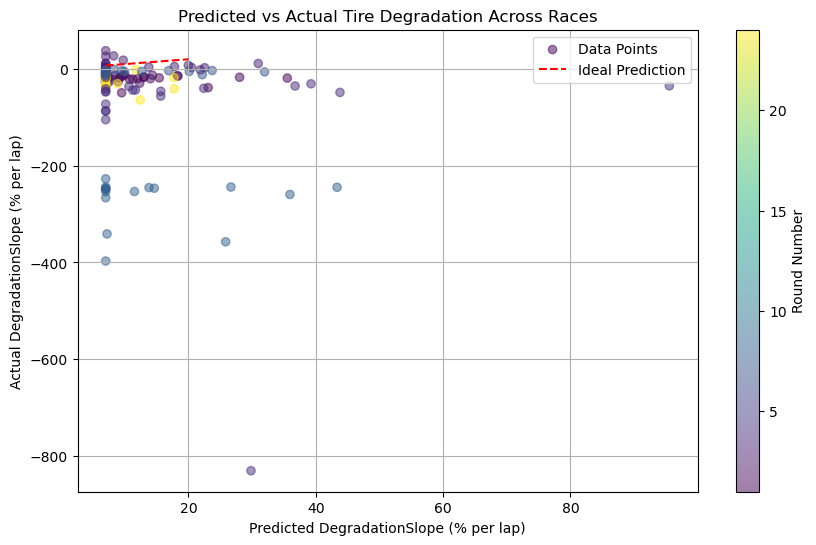

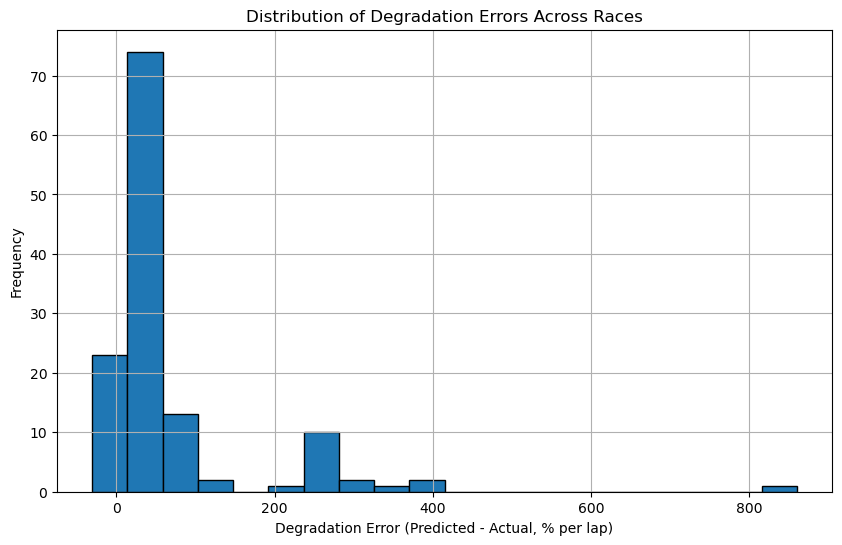

C:\Users\Elmar Conradie\AppData\Local\Temp\ipykernel_33080\1721489091.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_box.values, labels=df_box.columns)


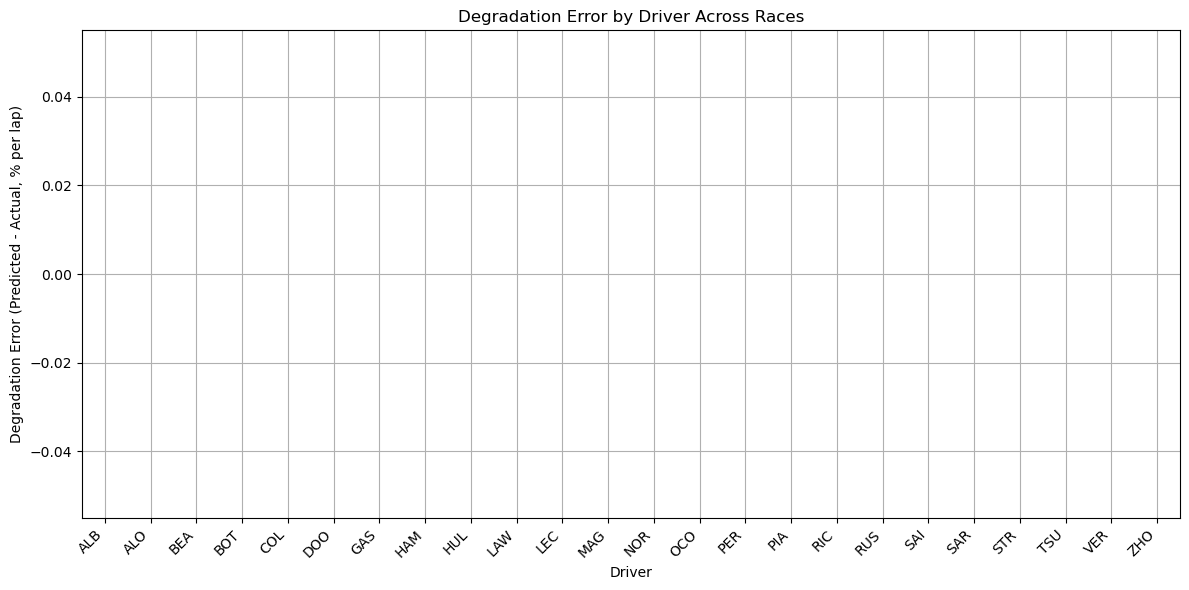


=== Insights and Suggestions ===
Significant errors detected in degradation predictions.
- **Issue**: Many drivers (e.g., Perez) default to 7.0%. Possible causes:
  - Insufficient long-run laps in Cell 5 (`TyreLife > 10` or IQR filter too strict).
  - Suggestion: Lower `TyreLife` threshold, relax IQR, or use a proxy (e.g., median degradation).
- **Issue**: Extreme values (>15%) detected (e.g., ALB, VER). Possible causes:
  - Too few laps, amplifying noise. Increase data by adjusting filters.
  - Disruptions (e.g., red flags). Filter affected laps in Cell 4.
- **General**: Review Cells 3-4 for data collection issues (e.g., missing laps, red flags).


In [55]:
# Step 14: Analyze Prediction Accuracy and Diagnose Data/Calculation Issues Across All Races

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def fetch_prediction_data(db_path='f1_fantasy.db', races=None):
    """
    Fetch prediction and actual data from the database.

    Args:
        db_path (str): Path to the SQLite database.
        races (list, optional): List of round numbers to filter. If None, use all races.

    Returns:
        pd.DataFrame: DataFrame with prediction and actual data.
    """
    conn = sqlite3.connect(db_path)

    # Query to fetch relevant data from results table
    query = """
    SELECT
        DegradationSlope,
        ActualDegradationSlope,
        DegError,
        PaceError,
        PositionError,
        RoundNumber,
        Driver
    FROM results
    WHERE DegradationSlope IS NOT NULL AND ActualDegradationSlope IS NOT NULL
    """

    if races is not None:
        race_list = ', '.join(map(str, races))
        query += f" AND RoundNumber IN ({race_list})"

    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        print(f"Error querying database: {e}")
        print("Available columns in results table:")
        # Inspect table schema
        schema_query = "PRAGMA table_info(results)"
        schema = pd.read_sql_query(schema_query, conn)
        print(schema['name'].tolist())
        conn.close()
        raise e

    conn.close()

    # Calculate DegError if not precomputed
    if 'DegError' not in df.columns or df['DegError'].isnull().any():
        df['DegError'] = df['DegradationSlope'] - df['ActualDegradationSlope']

    return df

def analyze_prediction_trends(df):
    """
    Analyze trends in prediction accuracy across races and drivers.

    Args:
        df (pd.DataFrame): DataFrame with prediction and actual data.

    Returns:
        None: Prints statistics and plots visualizations.
    """
    if df.empty:
        print("No data available for analysis.")
        return

    # Overall statistical analysis
    mean_deg_error = df['DegError'].mean()
    std_deg_error = df['DegError'].std()
    print(f"\n=== Overall Degradation Error Statistics ===")
    print(f"Mean Degradation Error (Predicted - Actual) across all races: {mean_deg_error:.4f}%")
    print(f"Std Dev of Degradation Error: {std_deg_error:.4f}%")

    # Correlation between predicted and actual degradation
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['DegradationSlope'], df['ActualDegradationSlope'])
    print(f"Correlation (R²) between Predicted and Actual Degradation: {r_value**2:.4f}, P-value: {p_value:.4f}")

    # Per-driver analysis
    driver_stats = df.groupby('Driver').agg({
        'DegError': ['mean', 'std', 'count'],
        'DegradationSlope': ['mean', 'max', 'min'],
        'ActualDegradationSlope': ['mean', 'max', 'min']
    }).round(4)
    print("\n=== Per-Driver Degradation Statistics ===")
    print(driver_stats)

    # Per-race analysis
    race_stats = df.groupby('RoundNumber').agg({
        'DegError': ['mean', 'std', 'count'],
        'DegradationSlope': ['mean', 'max', 'min'],
        'ActualDegradationSlope': ['mean', 'max', 'min']
    }).round(4)
    print("\n=== Per-Race Degradation Statistics ===")
    print(race_stats)

    # Identify anomalies
    zero_degradation_drivers = df[df['DegradationSlope'] == 7.0]['Driver'].unique()
    extreme_degradation_drivers = df[df['DegradationSlope'] > 15.0]['Driver'].unique()
    print(f"\n=== Anomalies ===")
    print(f"Drivers with Default Degradation (7.0%): {', '.join(zero_degradation_drivers)}")
    print(f"Drivers with Extreme Degradation (>15%): {', '.join(extreme_degradation_drivers)}")

    # Visualizations
    # Scatter plot: Predicted vs Actual Degradation
    plt.figure(figsize=(10, 6))
    plt.scatter(df['DegradationSlope'], df['ActualDegradationSlope'], alpha=0.5, c=df['RoundNumber'], cmap='viridis', label='Data Points')
    plt.colorbar(label='Round Number')
    plt.plot([7, 20], [7, 20], 'r--', label='Ideal Prediction')
    plt.xlabel('Predicted DegradationSlope (% per lap)')
    plt.ylabel('Actual DegradationSlope (% per lap)')
    plt.title('Predicted vs Actual Tire Degradation Across Races')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Histogram of Degradation Error
    plt.figure(figsize=(10, 6))
    plt.hist(df['DegError'], bins=20, edgecolor='black')
    plt.xlabel('Degradation Error (Predicted - Actual, % per lap)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Degradation Errors Across Races')
    plt.grid(True)
    plt.show()

    # Box plot of DegError by Driver
    plt.figure(figsize=(12, 6))
    df_box = df.pivot(columns='Driver', values='DegError')
    plt.boxplot(df_box.values, labels=df_box.columns)
    plt.xlabel('Driver')
    plt.ylabel('Degradation Error (Predicted - Actual, % per lap)')
    plt.title('Degradation Error by Driver Across Races')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Suggestions based on analysis
    print("\n=== Insights and Suggestions ===")
    if abs(mean_deg_error) > 0.1 or std_deg_error > 0.2:
        print("Significant errors detected in degradation predictions.")
        if len(zero_degradation_drivers) > len(df['Driver'].unique()) * 0.5:
            print("- **Issue**: Many drivers (e.g., Perez) default to 7.0%. Possible causes:")
            print("  - Insufficient long-run laps in Cell 5 (`TyreLife > 10` or IQR filter too strict).")
            print("  - Suggestion: Lower `TyreLife` threshold, relax IQR, or use a proxy (e.g., median degradation).")
        if len(extreme_degradation_drivers) > 0:
            print("- **Issue**: Extreme values (>15%) detected (e.g., ALB, VER). Possible causes:")
            print("  - Too few laps, amplifying noise. Increase data by adjusting filters.")
            print("  - Disruptions (e.g., red flags). Filter affected laps in Cell 4.")
        print("- **General**: Review Cells 3-4 for data collection issues (e.g., missing laps, red flags).")
    else:
        print("Degradation predictions align reasonably with actuals. Minor tuning may be needed.")

# Standalone use to call functions
# Use all races in the database (set races=None), or specify a list like races=[1, 2, 3]
df_predictions = fetch_prediction_data(races=None)  # Analyze all races
analyze_prediction_trends(df_predictions)

# Why: Analyzes prediction accuracy across all races to diagnose data/calculation issues.
# How to Read: Displays overall stats, per-driver/race breakdowns, anomaly flags, and plots.
# Expected Inputs: Data in f1_fantasy.db (populated by Cell 13).
# Expected Outputs: Stats, visualizations, and improvement suggestions.